# IMPACT OF CITY ELEVATION ON AIR QUALITY

## Importing dependencies and setup

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import requests
import json
import seaborn as sns
from scipy.stats import linregress
import datetime
from pprint import pprint
import plotly.express as px
from api_keys import weather_api_key

## Importing datasets of air quality data

In [2]:
# Loop through historical air quality data csv files in the historical_data folder
periods = ["2020", "2019Q1", "2019Q2", "2019Q3", "2019Q4","2015H1","2016H1","2017H1","2018H1"]

df_list = list()

for period in periods:
    path = f"historical_data/waqi-covid19-airqualitydata-{period}.csv"
    df = pd.read_csv(path)
    df_list.append(df)

In [3]:
# Combine individual air quality dataframes into one
airdf_2015_2020 = pd.concat(df_list, ignore_index=True)

In [4]:
airdf_2015_2020.head()

,Date,Country,City,Specie,count,min,max,median,variance
0,31/05/2020,IR,Isfahan,temperature,120,17.5,35.0,27.5,331.51
1,13/06/2020,IR,Isfahan,temperature,144,16.0,36.5,27.5,488.74
2,3/07/2020,IR,Isfahan,temperature,67,19.0,33.0,24.0,128.08
3,28/03/2020,IR,Isfahan,temperature,240,3.0,14.0,9.5,136.68
4,23/04/2020,IR,Isfahan,temperature,168,6.0,25.5,16.0,400.79


## Slicing and dicing the data

In [5]:
# Display an overview of the Specie column
airdf_2015_2020["Specie"].unique()

array(['temperature', 'wind-speed', 'wind-gust', 'dew', 'pm25',
       'humidity', 'wind speed', 'pressure', 'wind gust', 'co', 'so2',
       'precipitation', 'no2', 'pm10', 'o3', 'aqi', 'pol', 'uvi', 'wd',
       'neph', 'mepaqi', 'pm1', 'psi', 'd'], dtype=object)

In [6]:
# Display an overview of the number of rows each Specie has in the dataframe
airdf_2015_2020["Specie"].value_counts()

Specie
no2              569961
pm25             555518
pm10             553043
o3               545177
so2              474172
co               430596
temperature      334029
humidity         333932
pressure         331959
wind-speed       283664
dew              226147
wind-gust        187664
wind speed        47002
wd                29914
wind gust         29576
precipitation     28659
aqi               19568
uvi               14153
pol                4958
d                  2031
pm1                1756
neph               1553
mepaqi             1307
psi                 363
Name: count, dtype: int64

> Since we are focussing on air quality related to human activity and its correlation with elevation of a city we are focussing on 6 qualities of air quality and identify main source for these to be present in the atmosphere

    1. no2: combustion of fossil fuels (coal, gas and oil) especially fuel used in cars
    2. pm25: particles which are directly emitted into the atmosphere can originate from both natural sources, such as dust storms and forest fires, and anthropogenic sources, such as fossil fuel combustion, cigarette smoke, and biomass burning.
    3. pm10: also includes dust from construction sites, landfills and agriculture, wildfires and brush/waste burning, industrial sources, wind-blown dust from open lands, pollen and fragments of bacteria.
    4. o3: when pollutants emitted by cars, power plants, industrial boilers, refineries, chemical plants, and other sources chemically react in the presence of sunlight
    5. so2: sulfur dioxide released into the environment comes from electric utilities, especially those that burn coal. Some other sources of sulfur dioxide include petroleum refineries, cement manufacturing, paper pulp manufacturing, and metal smelting and processing facilities.
    6. co: results from the incomplete combustion of carbon-containing fuels such as natural gas, gasoline, or wood, and is emitted by a wide variety of combustion sources, including motor vehicles, power plants, wildfires, and incinerators.
    
    Hence, we'll remove data related to the following meteorology-related species: **temperature, humidity, pressure, wind-speed, dew, wind-gust, wind speed, wind gust, precipitation, wd (wind direction), uvi**. We'll also remove species with the least number of available data points  including **aqi, pol, pm1, mepaqi, neph,d, psi**.

In [7]:
species_to_remove = ["temperature", "humidity", "pressure", "wind-speed", "dew", "wind-gust",
                     "wind speed", "wind gust", "precipitation", "wd", "aqi", "uvi", "pol", "pm1", "mepaqi", "neph","d", "psi"]

short_airdf = airdf_2015_2020[~airdf_2015_2020["Specie"].isin(
    species_to_remove)].reset_index(drop=True).copy()

In [8]:
short_airdf.head()

,Date,Country,City,Specie,count,min,max,median,variance
0,24/02/2020,IR,Isfahan,pm25,129,54.0,194.0,126.0,10921.40
1,7/05/2020,IR,Isfahan,pm25,168,17.0,168.0,91.0,14014.00
2,28/05/2020,IR,Isfahan,pm25,127,17.0,115.0,72.0,3558.56
3,20/02/2020,IR,Isfahan,pm25,113,26.0,181.0,76.0,11209.80
4,23/02/2020,IR,Isfahan,pm25,132,22.0,132.0,76.0,3209.67


In [9]:
# Overview of the remaining air pollutant species in focus
short_airdf["Specie"].value_counts()

Specie
no2     569961
pm25    555518
pm10    553043
o3      545177
so2     474172
co      430596
Name: count, dtype: int64

> More details about the sources of the above major outdoor air pollutants can be referred to [source_outdoor_air_pollutants](https://learn.kaiterra.com/en/air-academy/5-major-outdoor-air-pollutants).

In [10]:
short_airdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3128467 entries, 0 to 3128466
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Date      object 
 1   Country   object 
 2   City      object 
 3   Specie    object 
 4   count     int64  
 5   min       float64
 6   max       float64
 7   median    float64
 8   variance  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 214.8+ MB


>Date column is of generic object type. Use to_datetime() function to convert the Date column into a datetime object. 

In [11]:
short_airdf["Date"] = pd.to_datetime(short_airdf["Date"], format="%d/%m/%Y")

In [12]:
# Double check the Date data type
short_airdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3128467 entries, 0 to 3128466
Data columns (total 9 columns):
 #   Column    Dtype         
---  ------    -----         
 0   Date      datetime64[ns]
 1   Country   object        
 2   City      object        
 3   Specie    object        
 4   count     int64         
 5   min       float64       
 6   max       float64       
 7   median    float64       
 8   variance  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 214.8+ MB


In [13]:
# Find the earliest date the air quality dataset covers:
short_airdf["Date"].min()

Timestamp('2014-12-29 00:00:00')

In [14]:
# Find the latest date the air quality dataset covers:
short_airdf["Date"].max()

Timestamp('2020-07-03 00:00:00')

In [15]:
# We will look at 24 month data as a starting point. Thus limitng our data from 1st Jun 2018 to 31st May 2020 
clean_airdf = short_airdf[(short_airdf["Date"] >= pd.to_datetime(
    "2018-06-01")) & (short_airdf["Date"] <= pd.to_datetime("2020-05-31"))].copy()

clean_airdf.head()

,Date,Country,City,Specie,count,min,max,median,variance
0,2020-02-24,IR,Isfahan,pm25,129,54.0,194.0,126.0,10921.40
1,2020-05-07,IR,Isfahan,pm25,168,17.0,168.0,91.0,14014.00
2,2020-05-28,IR,Isfahan,pm25,127,17.0,115.0,72.0,3558.56
3,2020-02-20,IR,Isfahan,pm25,113,26.0,181.0,76.0,11209.80
4,2020-02-23,IR,Isfahan,pm25,132,22.0,132.0,76.0,3209.67


In [16]:
# Set the starting date for the air quality analysis
starting_date = clean_airdf["Date"].min()
starting_date

Timestamp('2018-06-01 00:00:00')

In [17]:
# Set the cutoff date for the air quality analysis
end_date = clean_airdf["Date"].max()
end_date

Timestamp('2020-05-31 00:00:00')

In [18]:
# Display an overview of the Country column
clean_airdf["Country"].unique()

array(['IR', 'TJ', 'BR', 'CN', 'DK', 'ES', 'ML', 'SK', 'XK', 'CL', 'DE',
       'KW', 'MM', 'PH', 'PK', 'PL', 'RU', 'SE', 'SG', 'AE', 'BA', 'CZ',
       'ID', 'IS', 'MO', 'RO', 'AR', 'AU', 'EC', 'GH', 'HK', 'PE', 'UA',
       'EE', 'FR', 'JP', 'MN', 'FI', 'IE', 'IL', 'KZ', 'LA', 'UZ', 'BD',
       'BE', 'GR', 'KR', 'LK', 'MK', 'MX', 'TR', 'AF', 'AT', 'GT', 'BO',
       'CR', 'JO', 'PR', 'SA', 'SV', 'CA', 'IT', 'NO', 'RE', 'TM', 'ZA',
       'BH', 'LT', 'TH', 'BG', 'CH', 'HU', 'NL', 'NZ', 'UG', 'VN', 'ET',
       'GE', 'GN', 'IQ', 'RS', 'TW', 'CI', 'CO', 'CY', 'DZ', 'HR', 'IN',
       'KG', 'CW', 'GB', 'NP', 'PT', 'US'], dtype=object)

In [19]:
clean_airdf["Country"].nunique()

94

> There are 94 countries in the air quality data.

In [20]:
# Display an overview of the City column
clean_airdf["City"].unique()

array(['Isfahan', 'Arāk', 'Karaj', 'Qom', 'Orūmīyeh', 'Yazd', 'Īlām',
       'Kerman', 'Khorramshahr', 'Tabriz', 'Bandar Abbas', 'Sanandaj',
       'Kermanshah', 'Khorramabad', 'Shiraz', 'Zanjān', 'Mashhad',
       'Tehran', 'Dushanbe', 'São José dos Campos', 'Vitória',
       'São Paulo', 'Beijing', 'Jieyang', 'Kunming', 'Hangzhou',
       'Chongqing', 'Qingdao', 'Haikou', 'Ürümqi', 'Qiqihar', 'Guiyang',
       'Shenzhen', 'Yunfu', 'Xuchang', 'Yinchuan', 'Shenyang', 'Lhasa',
       'Shanghai', 'Changchun', 'Foshan', 'Nanning', 'Fushun', 'Hefei',
       'Chengdu', 'Hohhot', 'Qinhuangdao', 'Shijiazhuang', 'Shantou',
       'Zhengzhou', 'Nanjing', 'Xining', 'Xi’an', 'Zhuzhou', 'Wuhan',
       'Tianjin', 'Changzhou', 'Nanchang', 'Shiyan', 'Xinxiang', 'Suzhou',
       'Harbin', 'Lanzhou', 'Jinan', 'Changsha', 'Hegang', 'Anyang',
       'Wuxi', 'Taiyuan', 'Guangzhou', 'Fuzhou', 'Ningbo', 'Xiamen',
       'Dongguan', 'Copenhagen', 'Las Palmas de Gran Canaria',
       'Salamanca', 'Barcelona'

In [21]:
clean_airdf["City"].nunique()

602

> There are 602 cities in the air data. 

In [22]:
clean_airdf.head()

,Date,Country,City,Specie,count,min,max,median,variance
0,2020-02-24,IR,Isfahan,pm25,129,54.0,194.0,126.0,10921.40
1,2020-05-07,IR,Isfahan,pm25,168,17.0,168.0,91.0,14014.00
2,2020-05-28,IR,Isfahan,pm25,127,17.0,115.0,72.0,3558.56
3,2020-02-20,IR,Isfahan,pm25,113,26.0,181.0,76.0,11209.80
4,2020-02-23,IR,Isfahan,pm25,132,22.0,132.0,76.0,3209.67


In [23]:
clean_airdf_cols_trunc = clean_airdf[['City', 'Country', 'Specie', 'median', 'Date']]
clean_airdf_cols_trunc.head()

,City,Country,Specie,median,Date
0,Isfahan,IR,pm25,126.0,2020-02-24
1,Isfahan,IR,pm25,91.0,2020-05-07
2,Isfahan,IR,pm25,72.0,2020-05-28
3,Isfahan,IR,pm25,76.0,2020-02-20
4,Isfahan,IR,pm25,76.0,2020-02-23


In [24]:
# Transpose the clean_airdf so that the species will become the columns.
clean_airdf_transposed = clean_airdf.pivot_table(
    index=["Date", "Country", "City"], columns="Specie", values="median").copy()
clean_airdf_transposed.reset_index(inplace=True)

In [25]:
clean_airdf_transposed.head()

Specie,Date,Country,City,co,no2,o3,pm10,pm25,so2
0,2018-06-01,AE,Abu Dhabi,0.1,15.1,37.4,102.0,165.0,13.7
1,2018-06-01,AE,Dubai,NaN,NaN,NaN,NaN,172.0,NaN
2,2018-06-01,AR,Buenos Aires,3.5,6.9,9.0,16.0,34.0,3.1
3,2018-06-01,AT,Graz,0.1,8.0,NaN,21.0,NaN,1.1
4,2018-06-01,AT,Innsbruck,0.1,11.7,NaN,14.0,NaN,0.6


In [26]:
# Create a new column that captures month of each year
clean_airdf_transposed['year_month'] = clean_airdf_transposed["Date"].dt.to_period("M")
clean_airdf_transposed.head()

Specie,Date,Country,City,co,no2,o3,pm10,pm25,so2,year_month
0,2018-06-01,AE,Abu Dhabi,0.1,15.1,37.4,102.0,165.0,13.7,2018-06
1,2018-06-01,AE,Dubai,NaN,NaN,NaN,NaN,172.0,NaN,2018-06
2,2018-06-01,AR,Buenos Aires,3.5,6.9,9.0,16.0,34.0,3.1,2018-06
3,2018-06-01,AT,Graz,0.1,8.0,NaN,21.0,NaN,1.1,2018-06
4,2018-06-01,AT,Innsbruck,0.1,11.7,NaN,14.0,NaN,0.6,2018-06


In [27]:
#base_url1 = http://api.openweathermap.org/geo/1.0/direct?q={city name}&limit=5&appid={API key}

url = "http://api.openweathermap.org/geo/1.0/direct?"
lat_lon_list=[]

# Iterate through the arrays, clean_airdf["City"].unique()
for i in clean_airdf["City"].unique():
    # Create endpoint URL with each city
    city_url = f"{url}q={i}&appid={weather_api_key}"      
    # Make an API request 
    lat_lon = requests.get(city_url)
    
    # Convert the API response to JSON format
    lat_lon = lat_lon.json()
    #print(json.dumps(lat_lon, indent=4 ))
    
    for record in lat_lon:
        lat=record['lat']
        lon=record['lon']
        name=record['name']
        lat_lon_list.append({'lat': lat,
                              'lon': lon,
                              'City': name})

In [28]:
#Converting list into dataframe
lat_lon_list_df = pd.DataFrame(lat_lon_list)

In [29]:
url2 = 'https://api.open-elevation.com/api/v1/lookup?locations='
elevation_list = []

# Iterate through the combined DataFrame
for index, row in lat_lon_list_df.iterrows():
    # get lat and lon from the DataFrame
    lat1 = row['lat']
    lon1 = row['lon']
    # Create endpoint URL with each lat and lon
    elevation_url = f"{url2}{lat1},{lon}"  
    try:
    # Make and API request 
        elevation_data = requests.get(elevation_url)
    
    # Convert the API response to JSON format
        elevation_data = elevation_data.json()
        #print(json.dumps(elevation_data, indent=4 ))
        for record in elevation_data['results']:
            elevation=record['elevation']
            lat=record['latitude']
            elevation_list.append({'elevation': elevation,
                                   'lat': lat})
    # If an error is experienced, skip the city
    except:
        print("Data not found. Skipping...")

In [30]:
##Converting list into dataframe
elevation_list_df = pd.DataFrame(elevation_list)
elevation_list_df = elevation_list_df[['lat', 'elevation']]

In [31]:
#merging two dataframes from the above two APi
elevation_final_df = pd.merge(lat_lon_list_df, elevation_list_df, left_index=True, right_index=True)
elevation_final_df.head()

,lat_x,lon,City,lat_y,elevation
0,32.670788,51.665000,Isfahan,32.670788,0.0
1,34.086520,49.688842,Arak,34.086520,0.0
2,35.822489,50.990468,Karaj,35.822489,0.0
3,34.642294,50.880118,Qom,34.642294,0.0
4,37.548356,45.066755,Urmia,37.548356,64.0


In [32]:
#drop duplicate column
elevation_final_df = elevation_final_df.drop('lat_y', axis=1)

In [33]:
#rename column to original name
elevation_final_df = elevation_final_df.rename(columns={'lat_x': 'lat'})

In [34]:
#dropping elevation values=0
elevation_final_df = elevation_final_df[(elevation_final_df['elevation'] > 0)]
elevation_final_trun = elevation_final_df[['City','elevation']]
elevation_final_trun. head()

,City,elevation
4,Urmia,64.0
19,São José dos Campos,399.0
20,Vitória,195.0
21,São Paulo,404.0
22,Beijing,289.0


In [35]:
#csv export
elevation_final_df.to_csv("elev.csv", index_label="City_ID")

In [36]:
# Merge air quality file with elevation data

airq_elevation_city_df = pd.merge(clean_airdf_cols_trunc, elevation_final_trun, how="left",on=["City"])
rslt_df = airq_elevation_city_df[airq_elevation_city_df['elevation'] > 0] 
rslt_df

,City,Country,Specie,median,Date,elevation
9395,São José dos Campos,BR,pm10,10.0,2020-02-01,399.0
9396,São José dos Campos,BR,pm10,14.0,2020-02-19,399.0
9397,São José dos Campos,BR,pm10,23.0,2020-04-29,399.0
9398,São José dos Campos,BR,pm10,17.0,2020-01-08,399.0
9399,São José dos Campos,BR,pm10,20.0,2020-01-16,399.0
...,...,...,...,...,...,...
1469147,Hyderabad,IN,pm25,85.0,2018-06-09,1426.0
1469148,Hyderabad,IN,pm25,127.0,2018-06-01,1426.0
1469149,Hyderabad,IN,pm25,134.0,2018-06-03,1426.0
1469150,Hyderabad,IN,pm25,112.0,2018-06-04,1426.0


In [53]:
# Define a function to draw boxplots showing monthly distribution of median values of different air pollutants across 2019 and 2020H1
def specie_boxplot(specie):
    fig, ax = plt.subplots(figsize=(18, 24))

    red_diamond = dict(markerfacecolor='r', marker='D', alpha=0.3)
    sns.boxplot(data=clean_airdf_transposed, x='year_month',
                y=specie, flierprops=red_diamond)

    plt.xlabel("Year_Month", fontsize=16)
    plt.ylabel(specie, fontsize=16)

    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)

    plt.title(
        f"Monthly Distribution of Median {specie} in 94 countries between ({starting_date} and {end_date}), 24 month period", fontsize=12)
    plt.savefig(f"images/boxplot_{specie}.png")

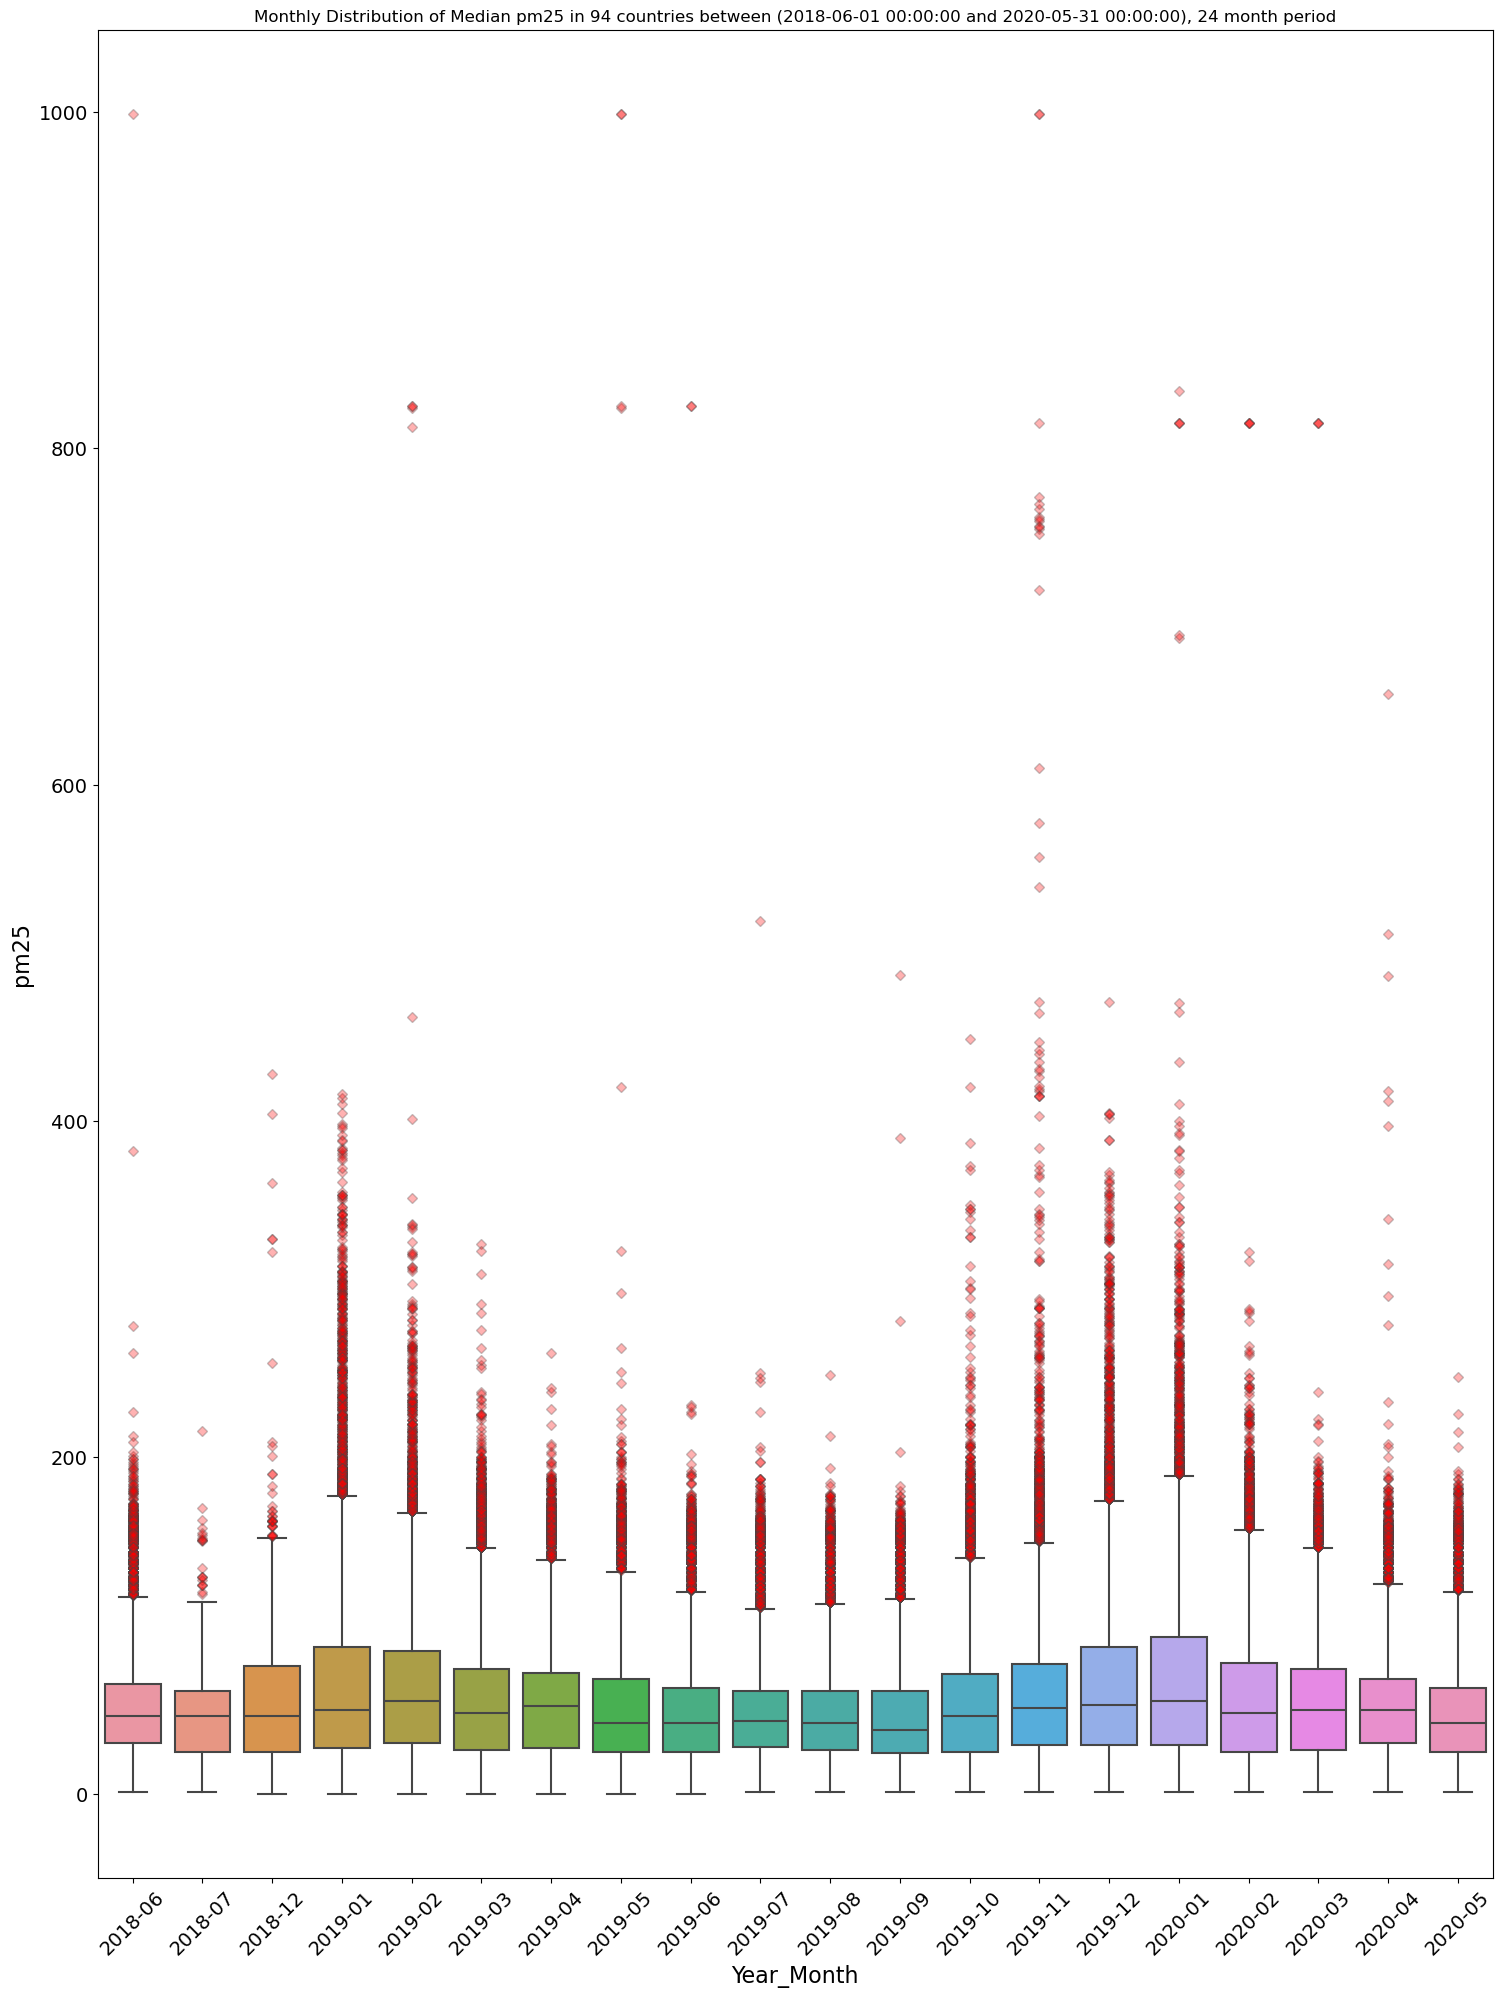

In [54]:
specie_boxplot("pm25")

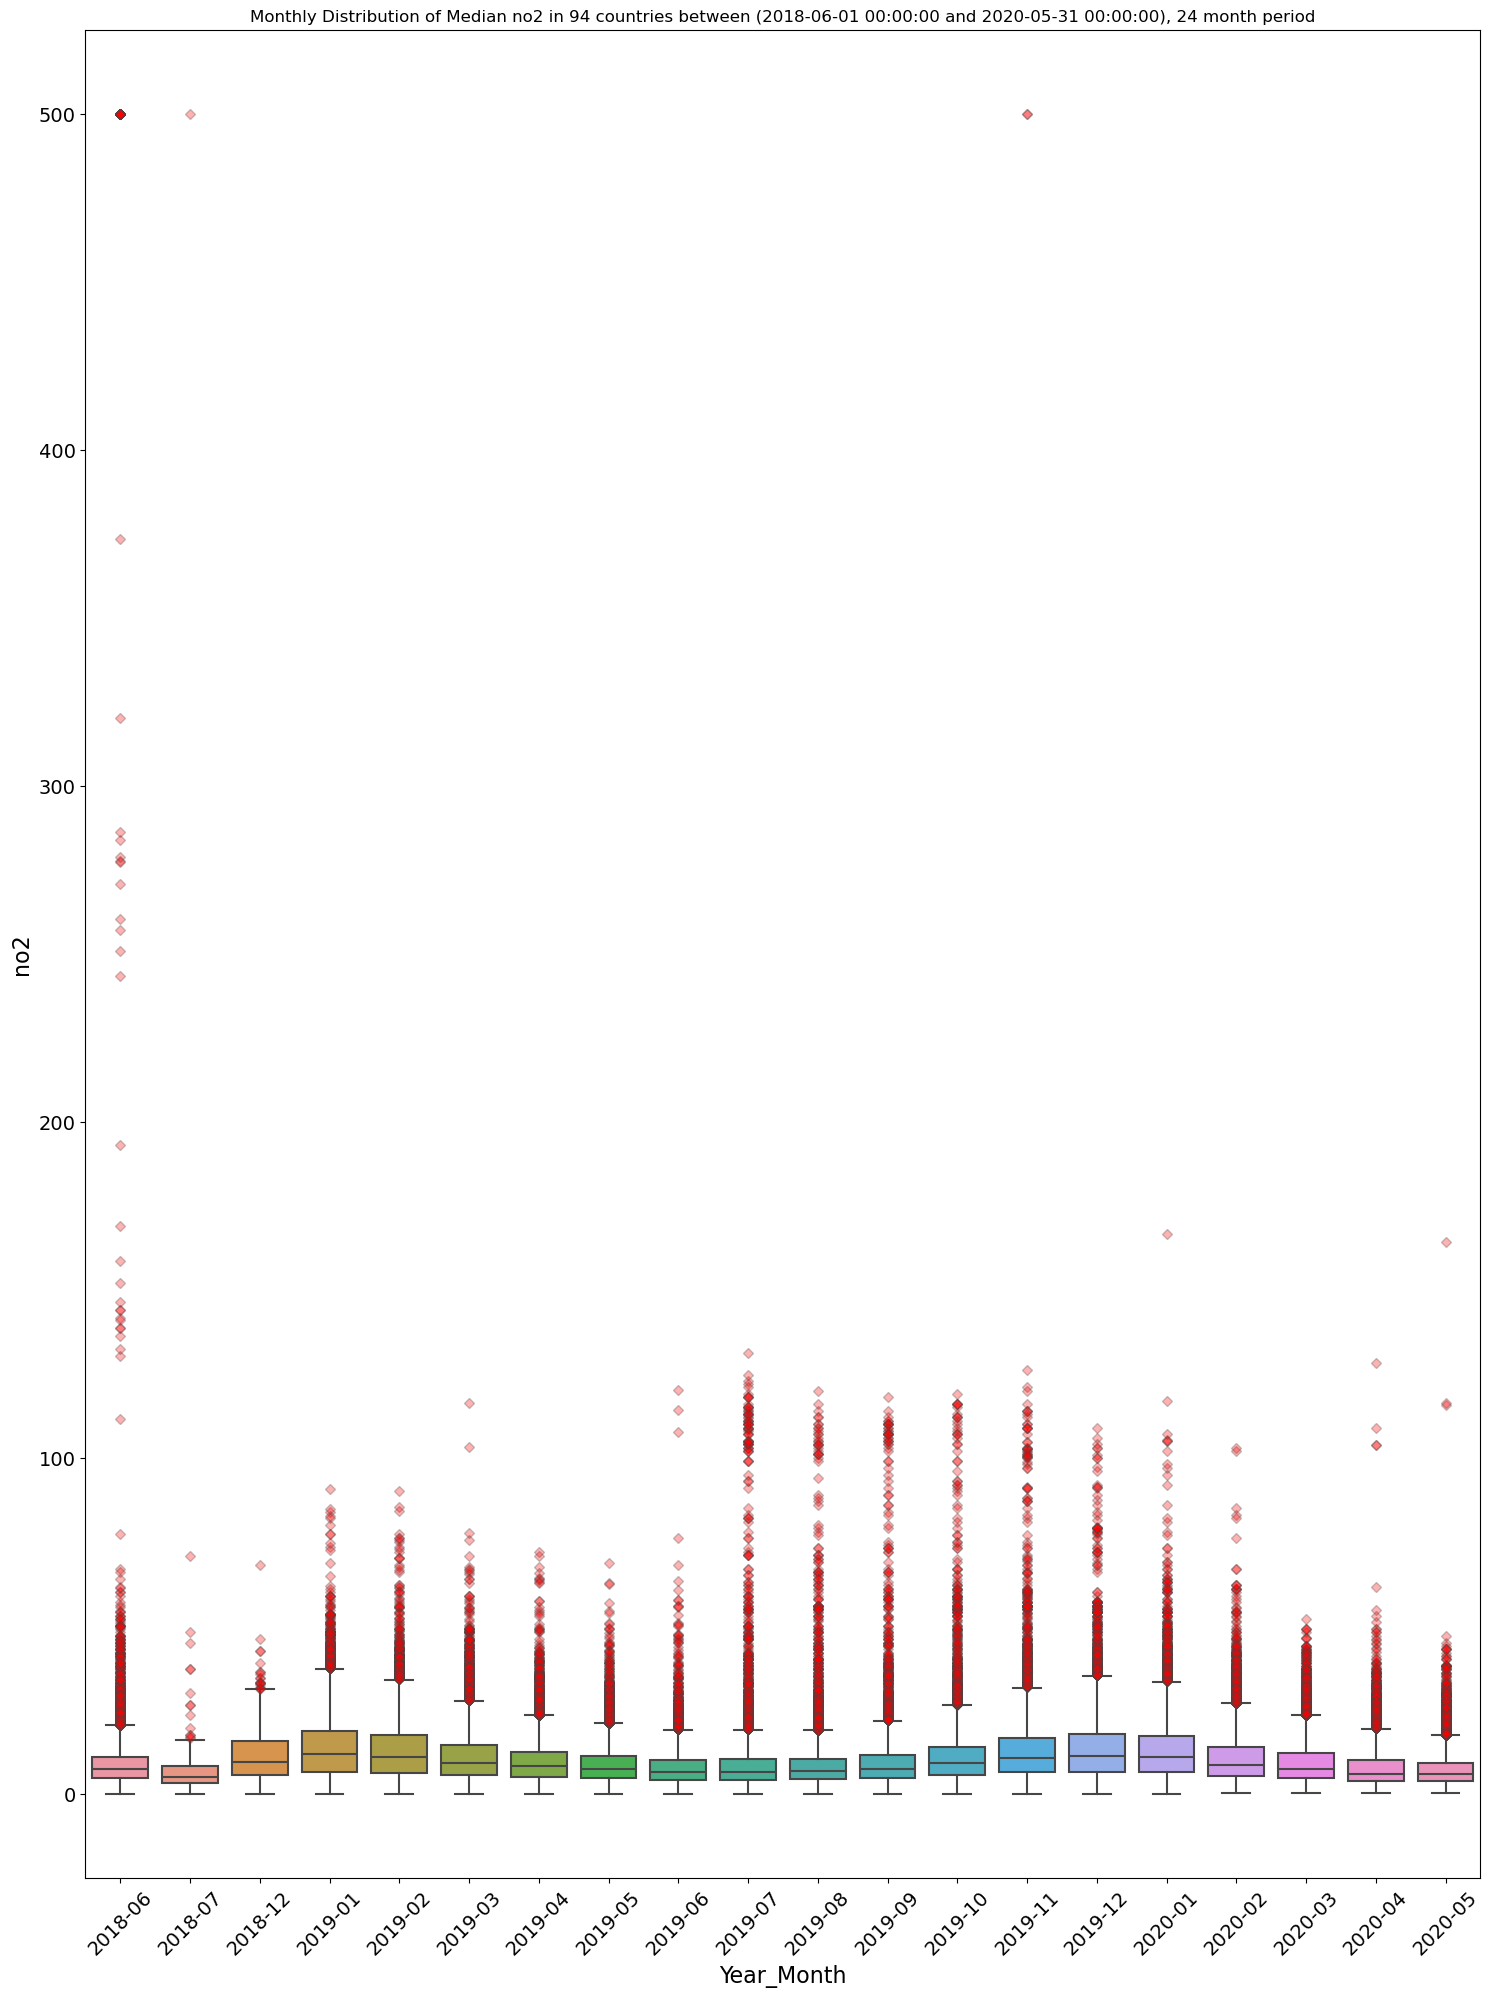

In [55]:
specie_boxplot("no2")

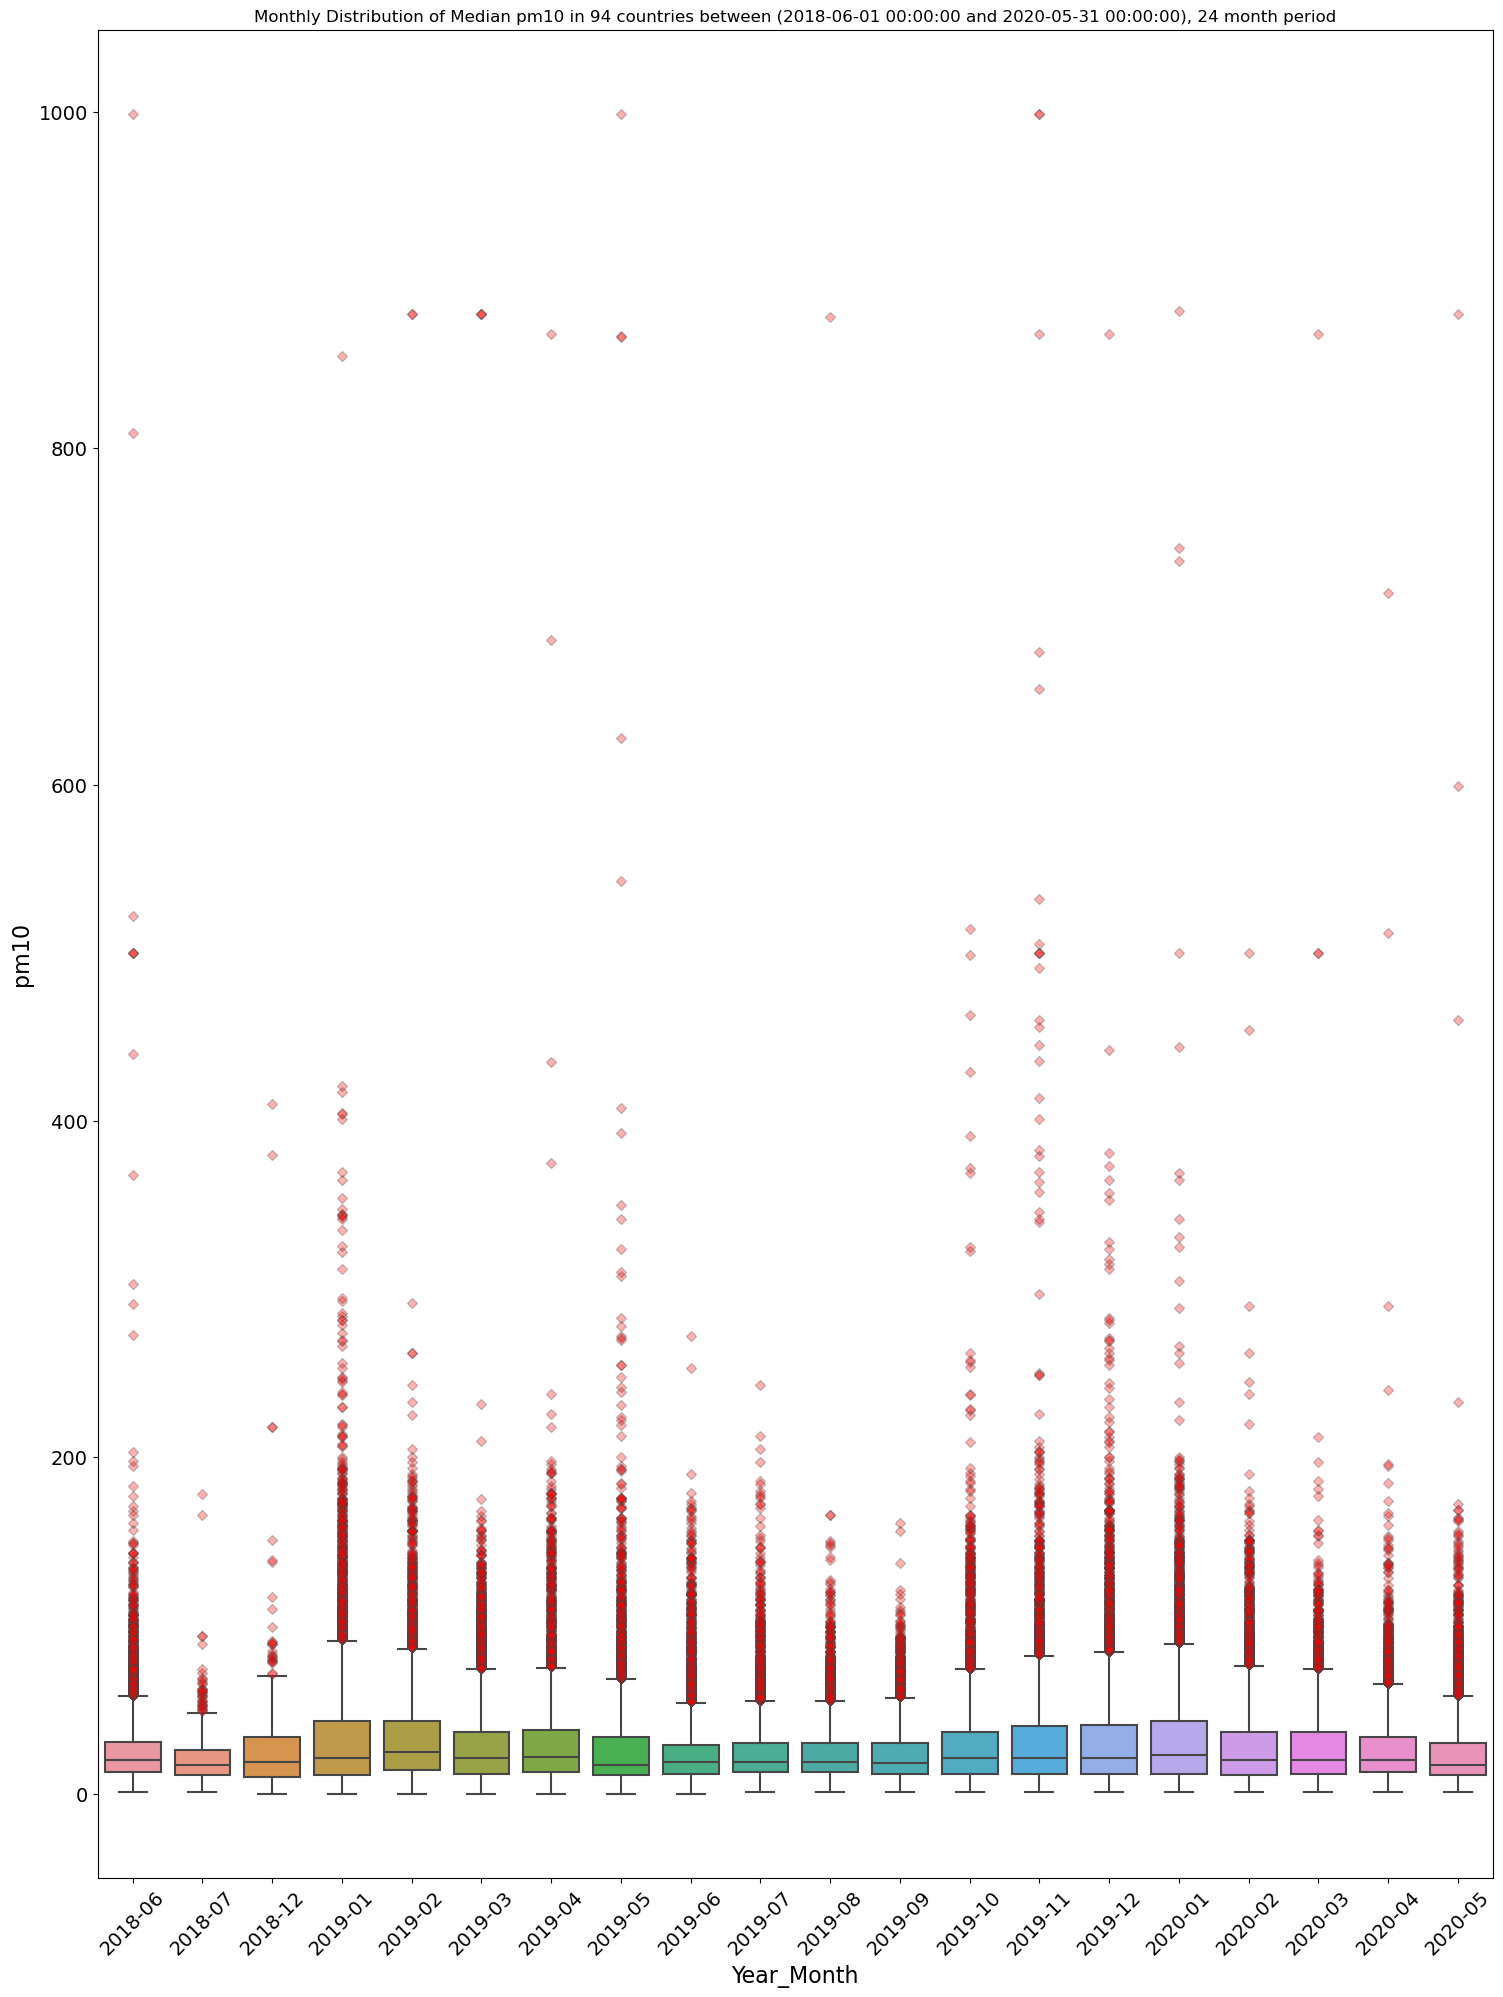

In [56]:
specie_boxplot("pm10")

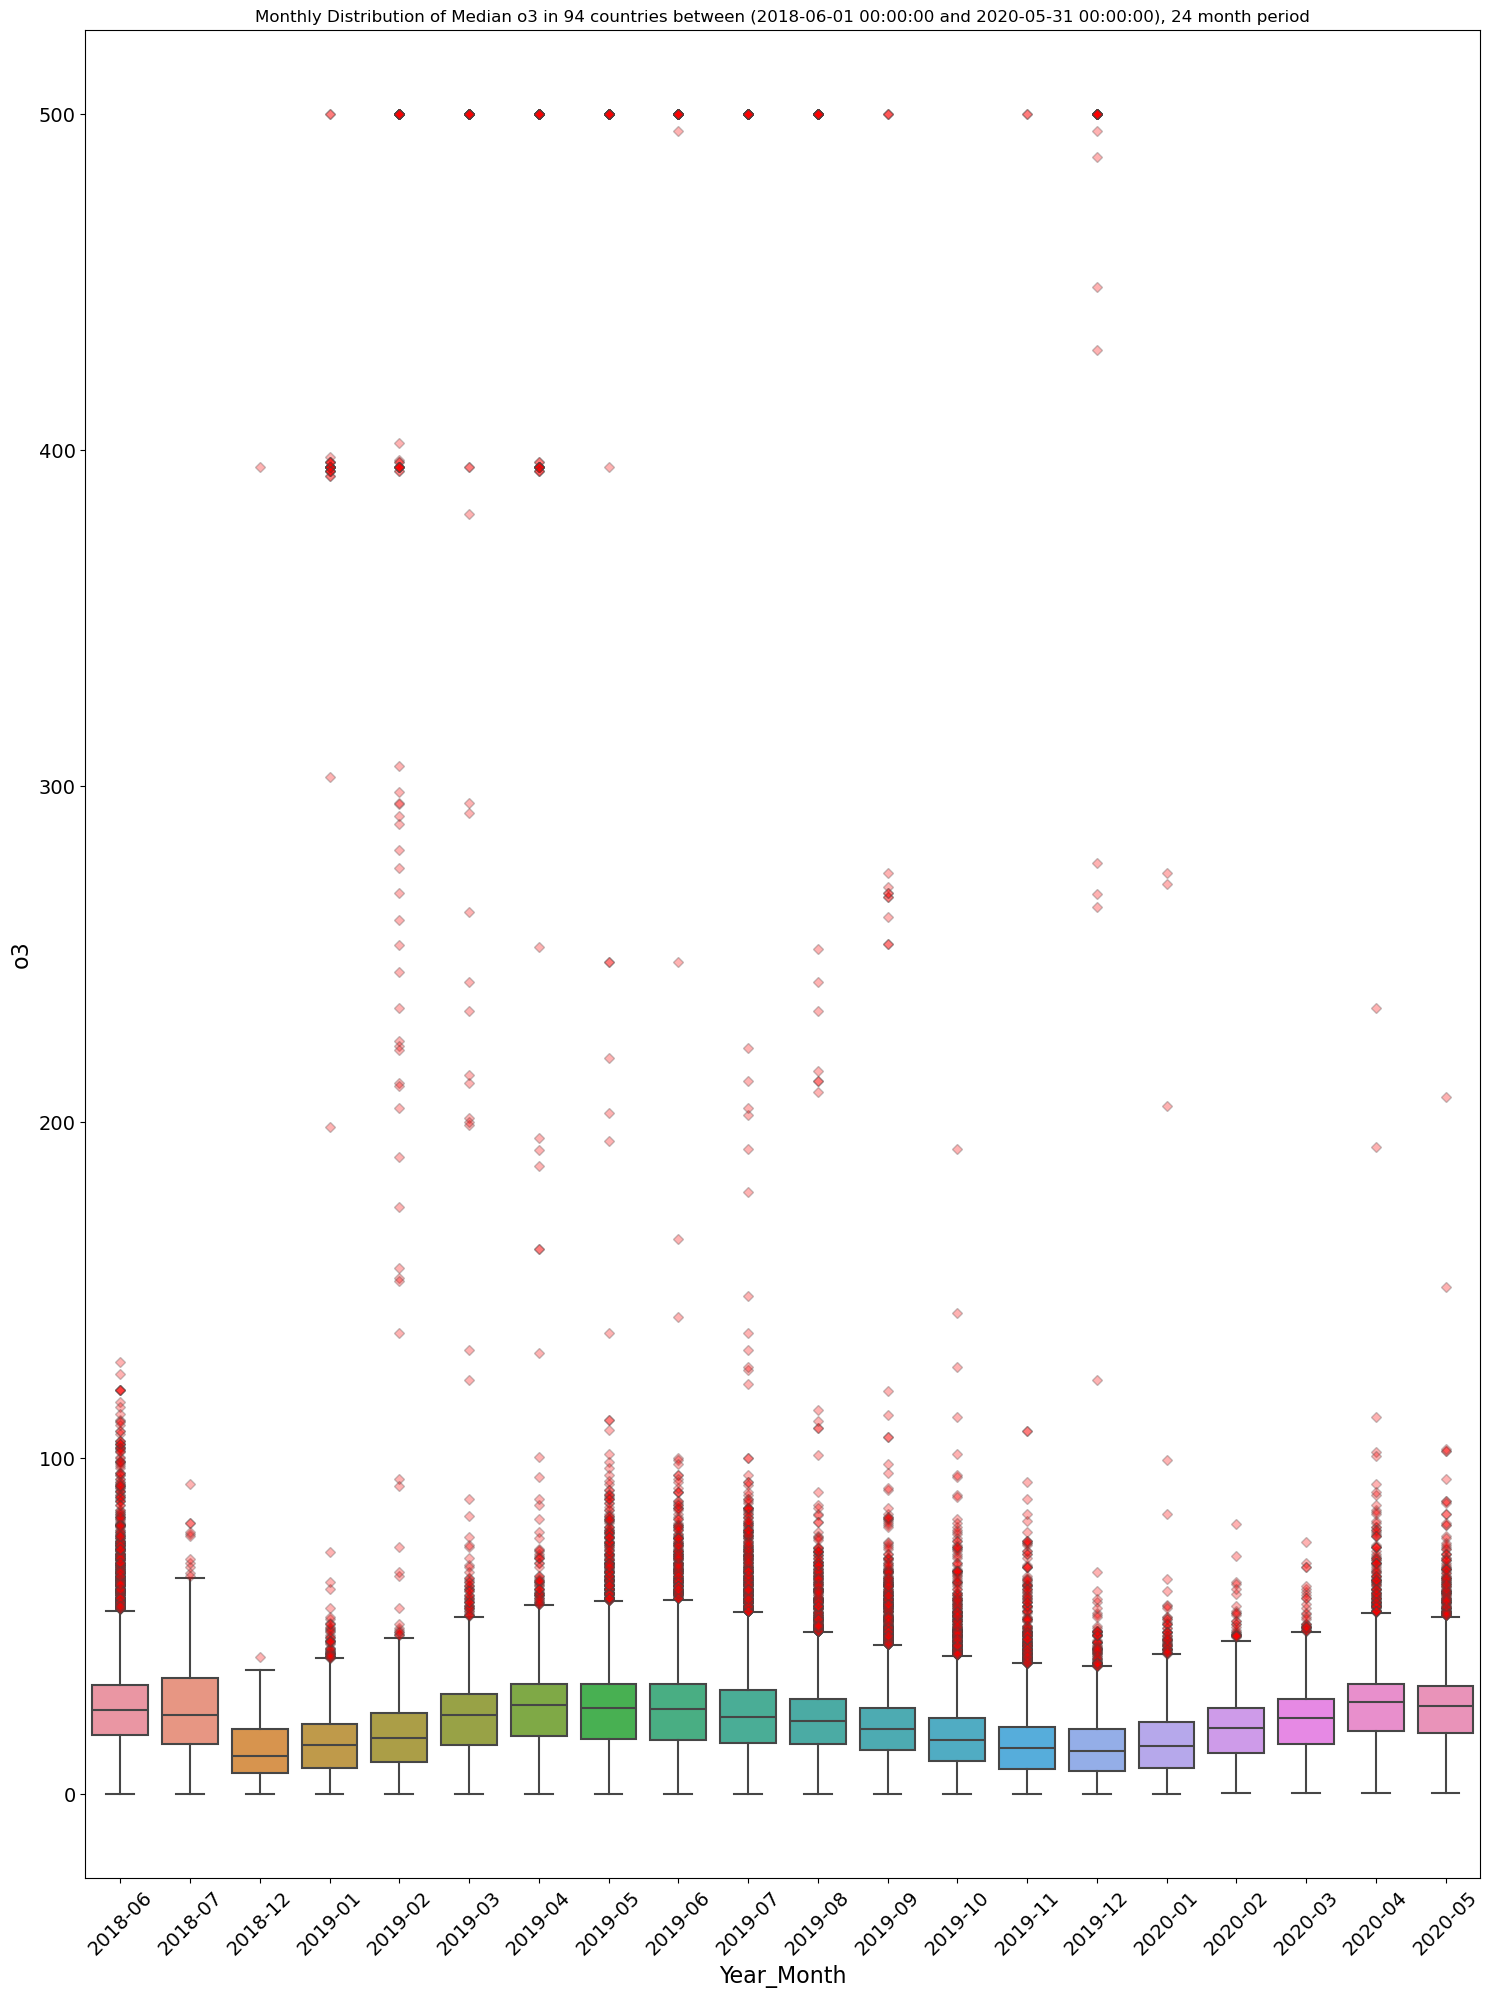

In [57]:
specie_boxplot("o3")

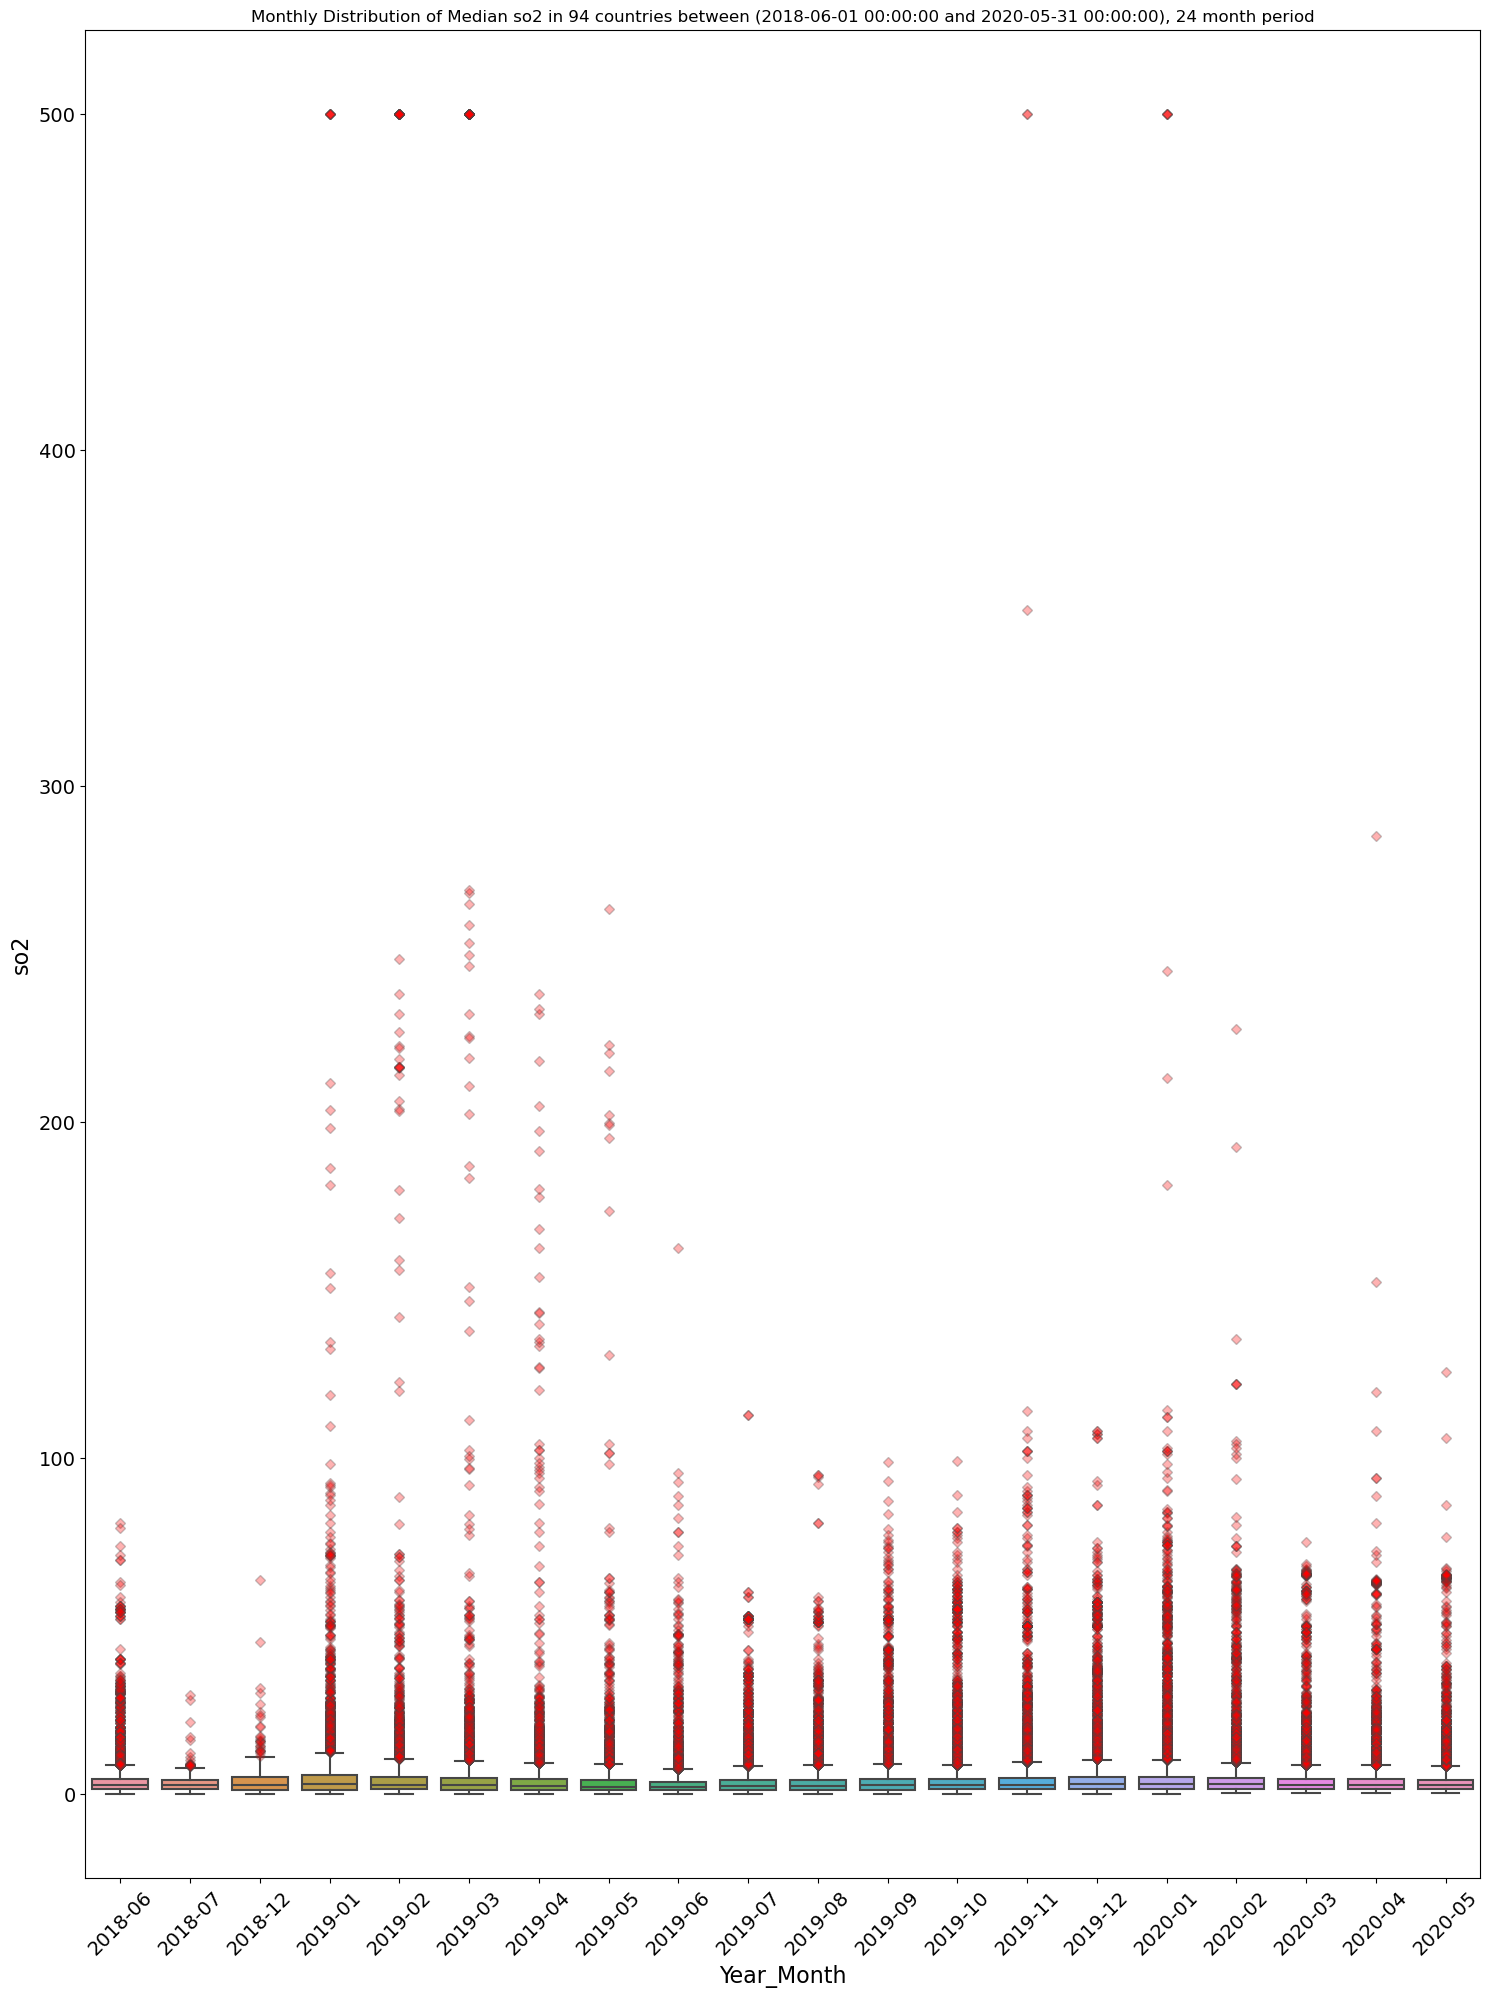

In [58]:
specie_boxplot("so2")

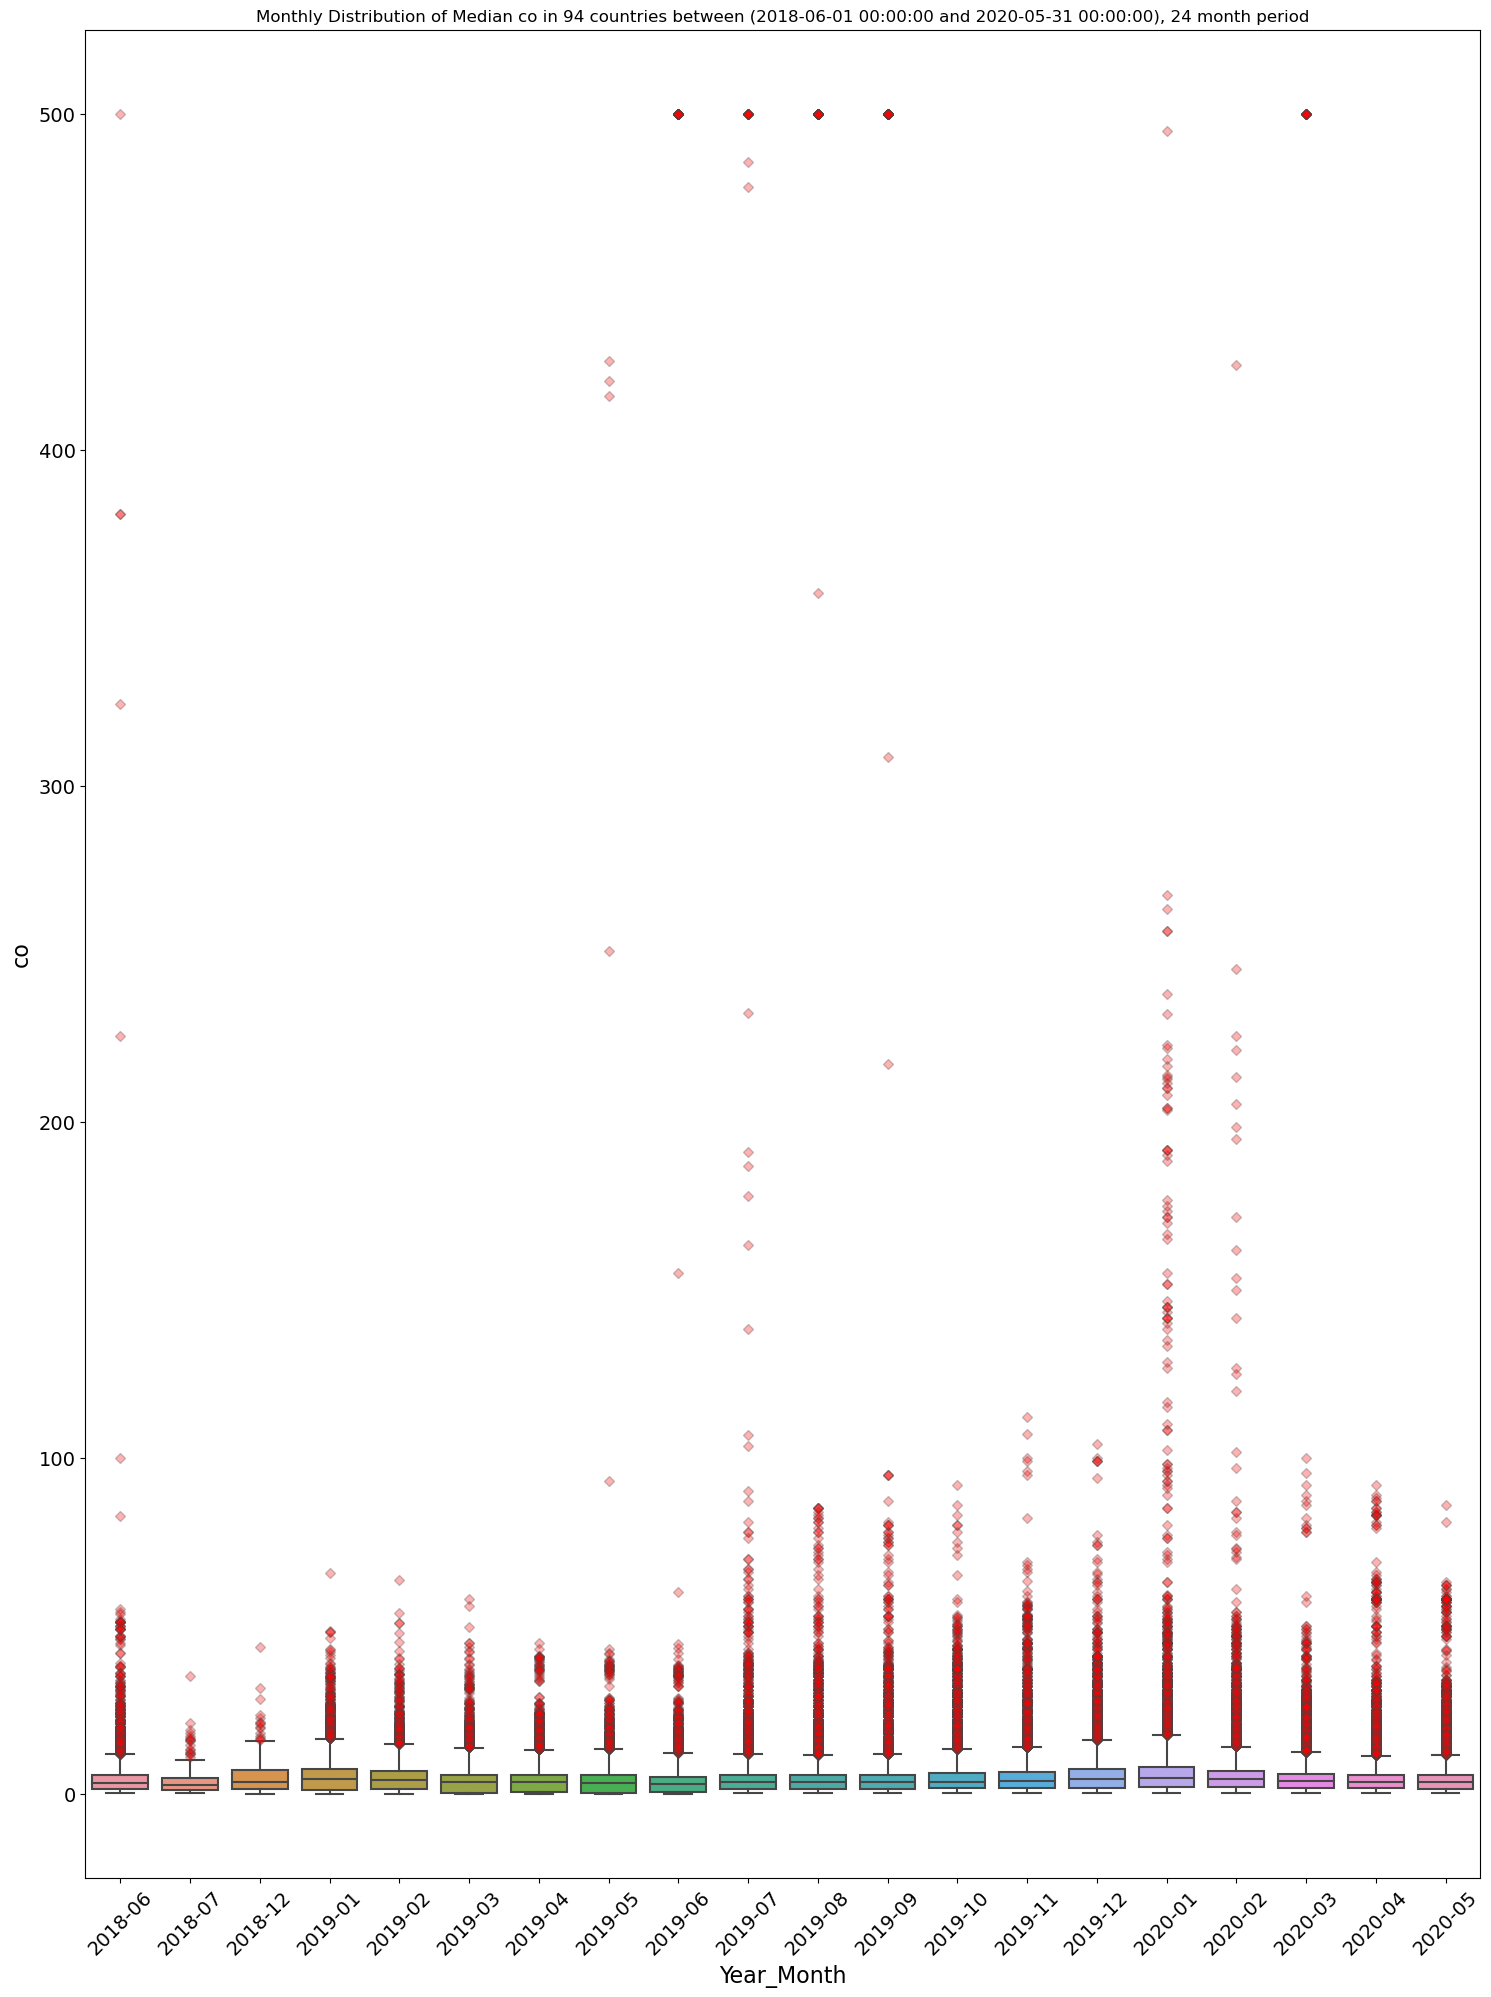

In [59]:
specie_boxplot("co")

> **Analysis of outliers and boxplots**
>
> Each of the boxplots for 6 pollutant categories shows presence of outliers
> 
> We have decided not to remove these outliers in our analysis. 3 reasons as below
> 
>  - The median for all 6 pollutants is largely in the centre of the box

>  - This tells us the data is tending towards beng symmetric

>  - Therefore we can now focus on specific cities in a country and look at 2 variables for thse countries namely population and elevation
> 
> **Next steps in analysis**
> 
> Identify cities with similar populations and differing elevations
> 
> Plot air quality data to check if elevation of a city is correlated to air quality 

## Visualise air quality change in India for 2 cities
> Delhi: Population 11m, Elevation 227m
> 
> Mumbai: Population 12m, Elevation 8m

In [60]:
# Filter out the clean_airdf part of Melbourne
del_air_df = clean_airdf.loc[(clean_airdf["Country"] == "IN") & (
    clean_airdf["City"] == "Delhi")].sort_values("Date").set_index("Date")
del_air_df.head()

,Country,City,Specie,count,min,max,median,variance
Date,,,,,,,,
2018-06-01,IN,Delhi,no2,442,1.0,169.8,11.8,4145.29
2018-06-01,IN,Delhi,co,398,0.1,230.2,7.3,1360.74
2018-06-01,IN,Delhi,o3,351,1.1,134.5,17.6,4264.22
2018-06-01,IN,Delhi,pm10,351,64.0,999.0,135.0,42088.40
2018-06-01,IN,Delhi,so2,440,0.4,38.0,6.2,301.77


In [61]:
# Overview of the air pollutants appearing in the Melbourne air quality data
del_air_df["Specie"].value_counts()

Specie
no2     562
co      562
o3      562
pm10    562
so2     562
pm25    562
Name: count, dtype: int64

In [62]:
# Define a function plotting air pollutant changes in Delhi using the rolling windows
# Rolling windows overlap and "roll" along at the same frequency as the data.
# Therefore, the transformed time series is at the same frequency as the original ones.


def del_air_specie(specie):
    specie_del_air = del_air_df[del_air_df["Specie"] == specie]
    rolling_median_specie_del_air = specie_del_air["median"].rolling(
        30, center=True).mean()
    rolling_median_specie_del_air.plot(figsize=(12, 5))

    plt.xlabel("Year_Month", fontsize=12)
    plt.xlim(starting_date, end_date)
    plt.ylabel(specie, fontsize=12)
    plt.title(
        f"30-day Moving Average of Median {specie} values in Delhi over 24 months", fontsize=14)

    plt.savefig(f"images/delhi_{specie}.png")

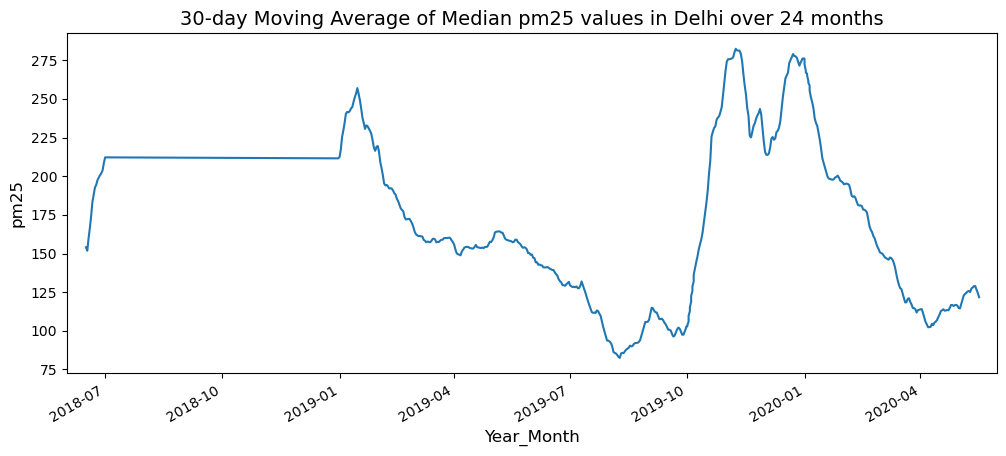

In [63]:
del_air_specie("pm25")

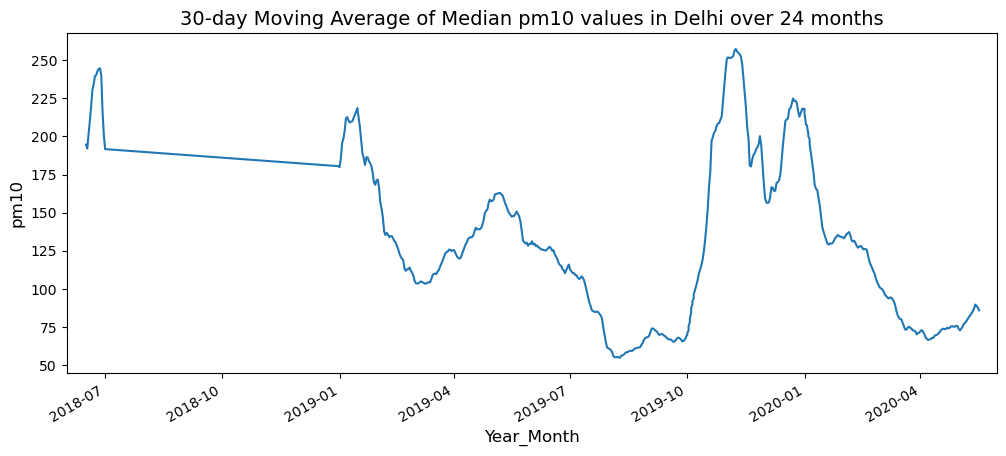

In [64]:
del_air_specie("pm10")

> The spike in particulate matter in Delhi during Oct - Jan periods can be attributed to winter season, where rural population will burn boimass to keep warmth

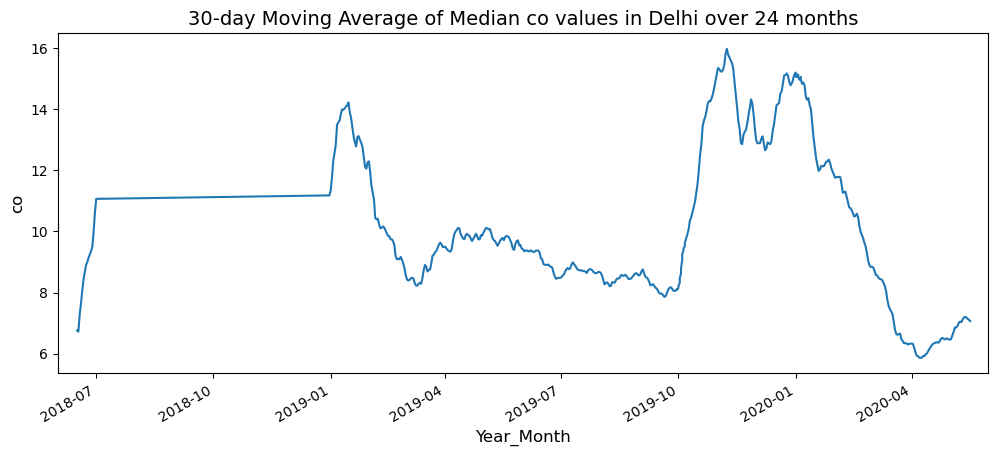

In [65]:
del_air_specie("co")

> The CO level in Delhi shows a seasonal rise possibly caused by fossil fuel combustion related to season and human activity 

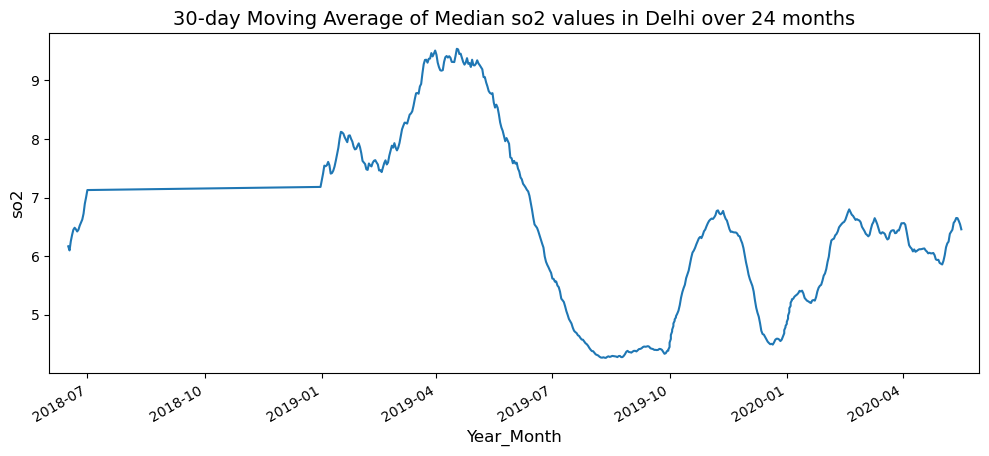

In [66]:
del_air_specie("so2")

> The SO2 level in Delhi dropped drastically from Apr 2019 extending into 2020. This maay be related to COVID restricitons causing a decline in human activity

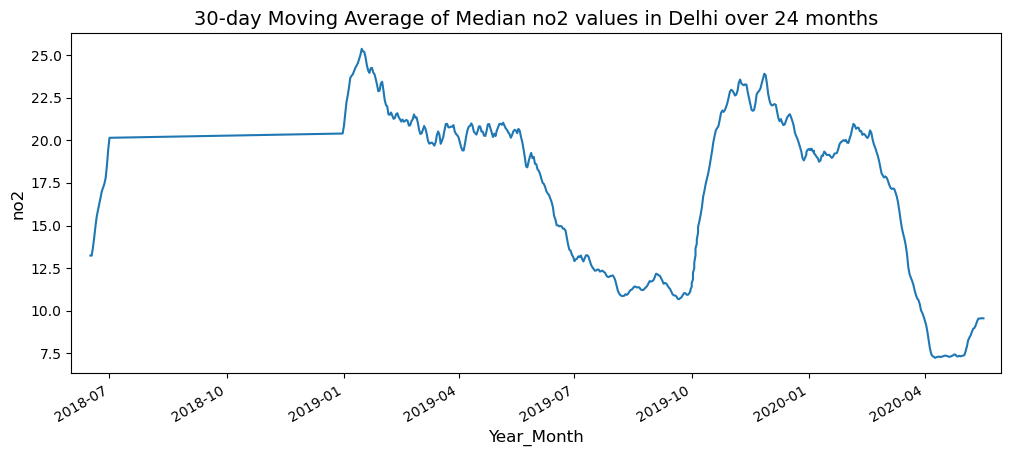

In [67]:
del_air_specie("no2")

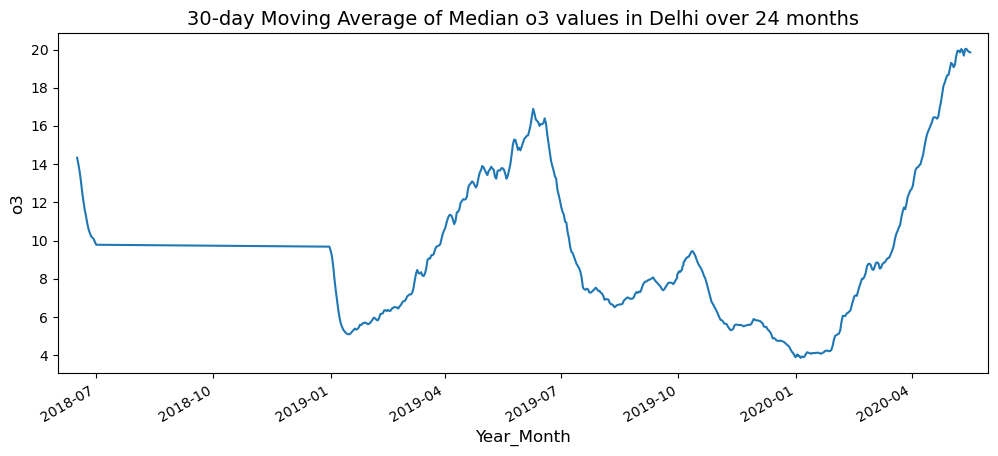

In [68]:
del_air_specie("o3")

> Delhi seems to experience a significant rise in human activity from Feb till the monsoons arrive in India in June, when the pollutant levels commence to decline

* **We now compare the air between Delhi and Mumbai**

In [69]:
# Define a function plotting air pollutant changes in different cities using the rolling windows


def specie_cities(df, city_list, specie):

    specie_cities_df = df[(df["City"].isin(city_list)) & (
        df["Specie"] == specie)].sort_values("Date").copy()
    specie_cities_transposed_df = specie_cities_df.pivot_table(
        index="Date", columns="City", values="median")
    rolling_specie_cities = specie_cities_transposed_df[city_list].rolling(
        7, center=True).mean()

    #plt.style.use('seaborn-bright')
    rolling_specie_cities.plot(figsize=(12, 5))

    plt.xlabel("Year_Month", fontsize=12)
    plt.xlim(starting_date, end_date)
    plt.ylabel(specie, fontsize=12)
    plt.title(
        f"7 day Moving Average of median {specie} in {city_list} in 24 months", fontsize=14)
    plt.savefig(f"images/{city_list}_{specie}.png")

In [70]:
# Filter out air quality data for Australia

in_air_df = clean_airdf.loc[clean_airdf["Country"] == "IN"]
in_air_df.head()

,Date,Country,City,Specie,count,min,max,median,variance
422490,2020-02-24,IN,Thrissur,co,24,2.1,11.2,5.3,58.36
422491,2020-04-07,IN,Thrissur,co,72,2.3,13.6,8.1,131.11
422492,2020-04-24,IN,Thrissur,co,67,1.4,12.2,9.2,126.02
422497,2020-01-03,IN,Thrissur,co,24,3.2,16.7,8.6,176.06
422498,2020-01-20,IN,Thrissur,co,21,0.4,10.6,5.1,105.15


In [71]:
in_cities_list = ["Delhi", "Mumbai"]

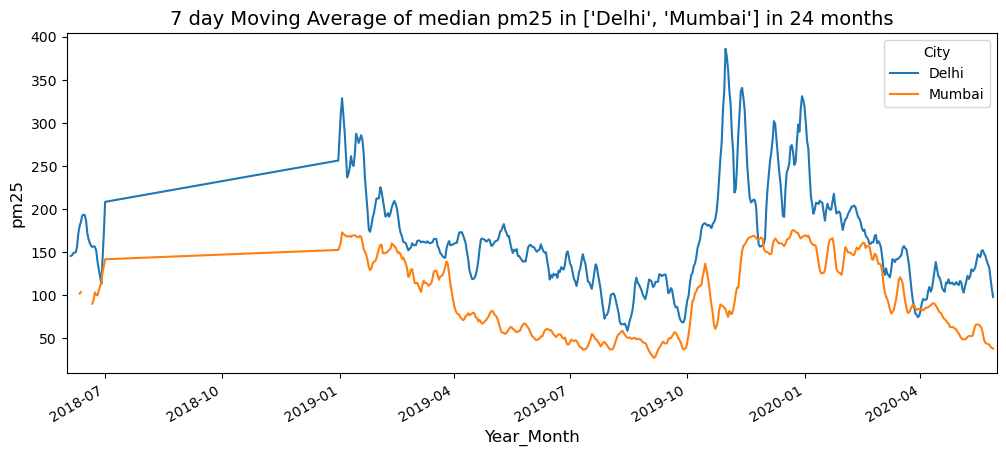

In [72]:
specie_cities(df=in_air_df, city_list=in_cities_list, specie="pm25")

> Delhi trends over Mumbai consistently in pm25. Clearly seasonal variations caused by elevation impact air quality

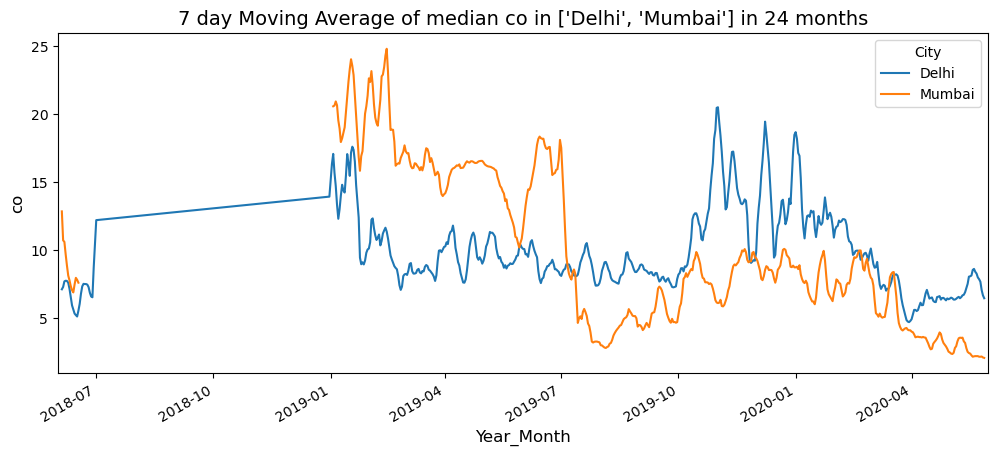

In [73]:
specie_cities(df=in_air_df, city_list=in_cities_list, specie="co")

> CO emissions in Mumbai have significantly fallen in 2020 while those in Delhi have maintained their trend and are trending above Mumbai in 2020 COVID and significant uptake in electric vehicles compared to Delhi could be contributing factors

##  Visualise air quality change in China for 2 cities
>
> Guangzao: Population 19m. Elevation 21m
>
>Chengdu:  Population 21m. Elevation 529m

In [74]:
# Filter out air quality data for China

cn_air_df = clean_airdf.loc[clean_airdf["Country"] == "CN"]
cn_air_df.head()

,Date,Country,City,Specie,count,min,max,median,variance
14794,2020-03-13,CN,Beijing,co,276,1.0,8.2,2.8,14.10
14795,2020-03-23,CN,Beijing,co,427,1.0,9.1,4.6,18.34
14796,2020-03-26,CN,Beijing,co,265,1.0,10.0,2.8,42.63
14797,2020-04-08,CN,Beijing,co,428,1.9,10.0,4.6,25.10
14799,2020-01-02,CN,Beijing,co,434,5.4,25.3,11.8,88.73


In [75]:
# Overview of the cities in the air data for China
cn_air_df["City"].value_counts()

City
Beijing         3378
Zhuzhou         3378
Qinhuangdao     3378
Shijiazhuang    3378
Jieyang         3378
Zhengzhou       3378
Nanjing         3378
Xining          3378
Xi’an           3378
Nanchang        3378
Fushun          3378
Harbin          3378
Lanzhou         3378
Changsha        3378
Anyang          3378
Taiyuan         3378
Fuzhou          3378
Xiamen          3378
Chengdu         3378
Shantou         3378
Nanning         3378
Guiyang         3378
Kunming         3378
Ürümqi          3378
Changchun       3378
Qiqihar         3378
Lhasa           3378
Shenyang        3378
Yinchuan        3378
Haikou          3378
Chongqing       3378
Qingdao         3378
Hegang          3377
Hefei           3377
Xinxiang        3376
Jinan           3376
Hangzhou        3374
Xuchang         3362
Wuhan           3357
Shenzhen        3356
Shanghai        3347
Guangzhou       3343
Dongguan        3343
Foshan          3343
Yunfu           3342
Ningbo          3078
Suzhou          3051
Changzho

In [76]:
# Overview of the air pollutants in the air data for China
cn_air_df["Specie"].value_counts()

Specie
pm25    29223
so2     29223
co      29222
pm10    29222
no2     29222
o3      26332
Name: count, dtype: int64

In [77]:
cn_cities_list = ["Chengdu", "Guangzhou"]

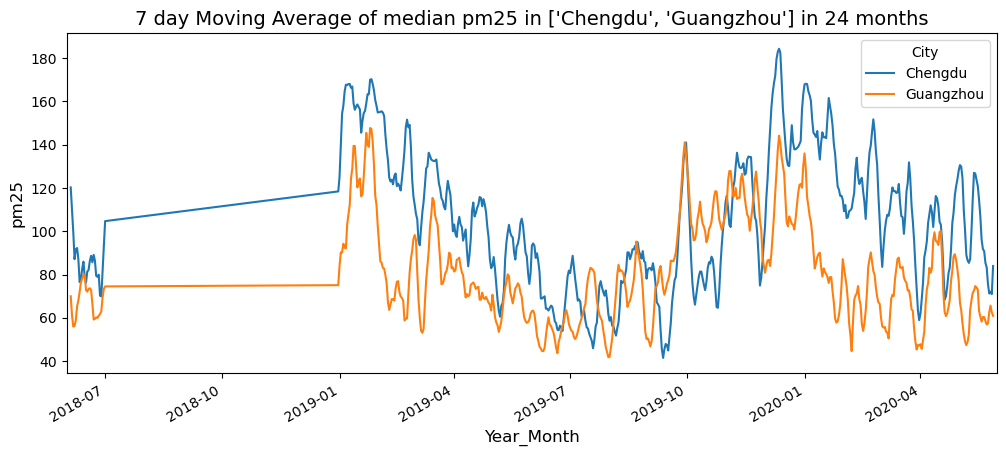

In [78]:
specie_cities(df=cn_air_df, city_list=cn_cities_list, specie="pm25")

> Chendu mirrors the trend as in Delhi, wherein seasonal cold weather is influencing pm25. And this seasonal variation is related to its elevation compared to Guangzhou

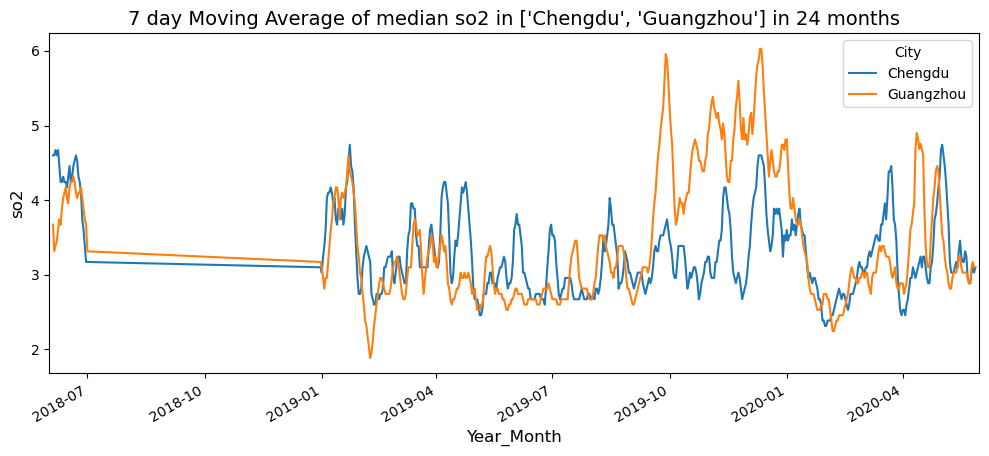

In [79]:
specie_cities(df=cn_air_df, city_list=cn_cities_list, specie="so2")

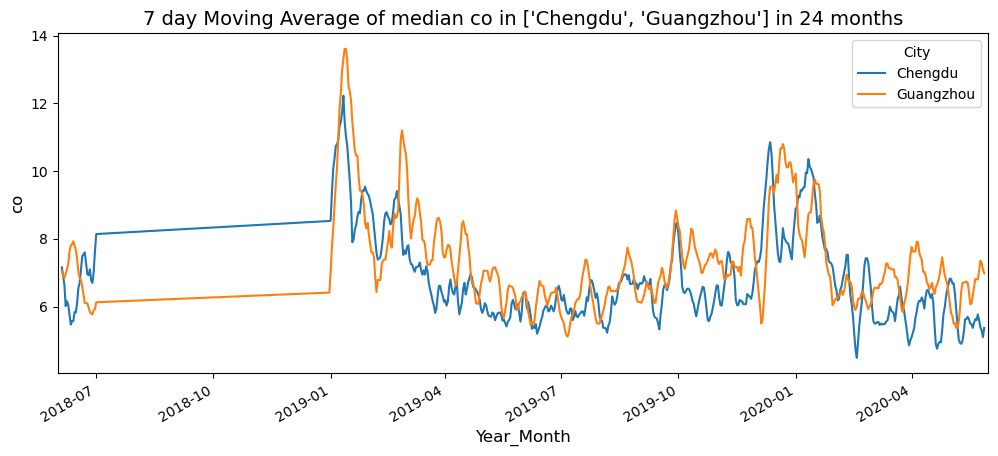

In [80]:
specie_cities(df=cn_air_df, city_list=cn_cities_list, specie="co")

> Guangzhao is a significant established manufacturing centre and Chengdu is an upcoming logistics hub. Both are mirroring the same trend for CO and SO2

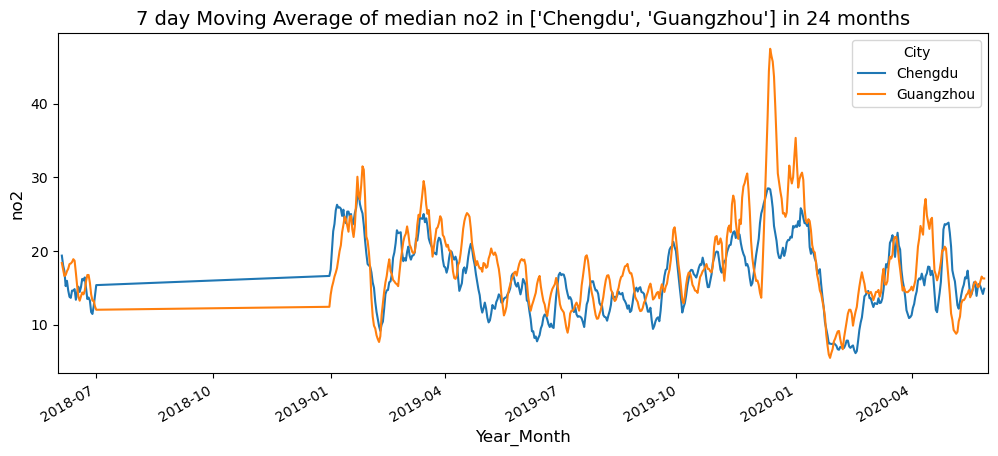

In [81]:
specie_cities(df=cn_air_df, city_list=cn_cities_list, specie="no2")

> Guangzhao is a significant established manufacturing centre and Chengdu is an upcoming logistics hub. Both are mirroring the same trend for CO, SO2 and NO2
>
> Implcations for Chengdu though because of its elevation in terms of air pollution as evidenced by pm25 could be more intense as economic activity increases in Chengdu

## Visualise air quality in Mumbai and Chengdu
>
>Mumbai has a population of 12m and elevation of 8m
>
>Chengdu has a population of 21m and elevation of 529m
>
>Given higher elevation and 80% more population it will interesting to see if air quality can be influenced by interventions


In [82]:
in_air_df.head()

,Date,Country,City,Specie,count,min,max,median,variance
422490,2020-02-24,IN,Thrissur,co,24,2.1,11.2,5.3,58.36
422491,2020-04-07,IN,Thrissur,co,72,2.3,13.6,8.1,131.11
422492,2020-04-24,IN,Thrissur,co,67,1.4,12.2,9.2,126.02
422497,2020-01-03,IN,Thrissur,co,24,3.2,16.7,8.6,176.06
422498,2020-01-20,IN,Thrissur,co,21,0.4,10.6,5.1,105.15


In [83]:
# Filter the air data for Mumbai
mumbai_air_df = in_air_df[in_air_df["City"] == "Mumbai"].sort_values(
    "Date").set_index("Date").copy()
mumbai_air_df.head()

,Country,City,Specie,count,min,max,median,variance
Date,,,,,,,,
2018-06-01,IN,Mumbai,pm10,24,65.0,83.0,69.0,354.18
2018-06-01,IN,Mumbai,pm25,23,87.0,134.0,107.0,2517.94
2018-06-01,IN,Mumbai,so2,24,16.5,23.6,18.0,57.23
2018-06-01,IN,Mumbai,co,24,10.8,26.2,25.3,431.74
2018-06-02,IN,Mumbai,so2,24,16.0,22.3,19.7,54.31


In [84]:
# Filter the air data for Chengdu
chengdu_air_df = cn_air_df[cn_air_df["City"] == "Chengdu"].sort_values(
    "Date").set_index("Date").copy()
chengdu_air_df.head()

,Country,City,Specie,count,min,max,median,variance
Date,,,,,,,,
2018-06-01,CN,Chengdu,pm10,602,14.0,100.0,59.0,1630.00
2018-06-01,CN,Chengdu,co,582,2.0,16.0,6.0,52.20
2018-06-01,CN,Chengdu,no2,620,0.5,45.7,15.6,630.35
2018-06-01,CN,Chengdu,pm25,656,38.0,824.0,129.0,15983.00
2018-06-01,CN,Chengdu,o3,619,0.5,91.6,28.5,2222.85


In [85]:
# Define a function plotting air pollutant changes in Mumbai and Chengdu using the rolling windows


def che_mum_air_specie(specie):
    specie_mumbai_air = mumbai_air_df[mumbai_air_df["Specie"] == specie]
    specie_che_air = chengdu_air_df[chengdu_air_df["Specie"] == specie]

    rolling_median_specie_mumbai_air = specie_mumbai_air["median"].rolling(
        30, center=True).mean()
    rolling_median_specie_mumbai_air.plot(figsize=(12, 5), label="Mumbai")
    rolling_median_specie_che_air = specie_che_air["median"].rolling(
        30, center=True).mean()
    rolling_median_specie_che_air.plot(figsize=(12, 5), label="Chengdu")

    plt.xlabel("Year_Month", fontsize=12)
    plt.xlim(starting_date, end_date)
    plt.ylabel(specie, fontsize=12)
    plt.legend()
    plt.title(f"30-day Moving Average of Median {specie} values in Chengdu and Mumbai", fontsize=14)
    plt.savefig(f"images/chengdu_mumbai_{specie}.png")

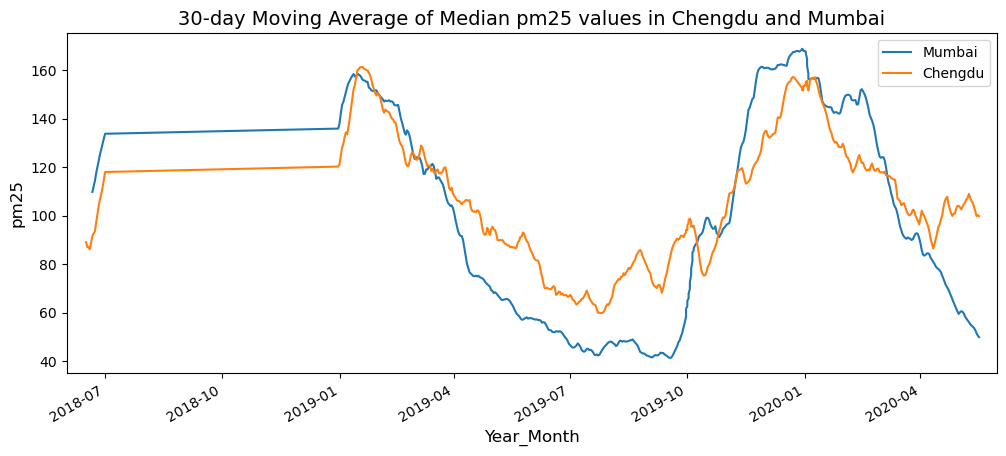

In [86]:
che_mum_air_specie("pm25")

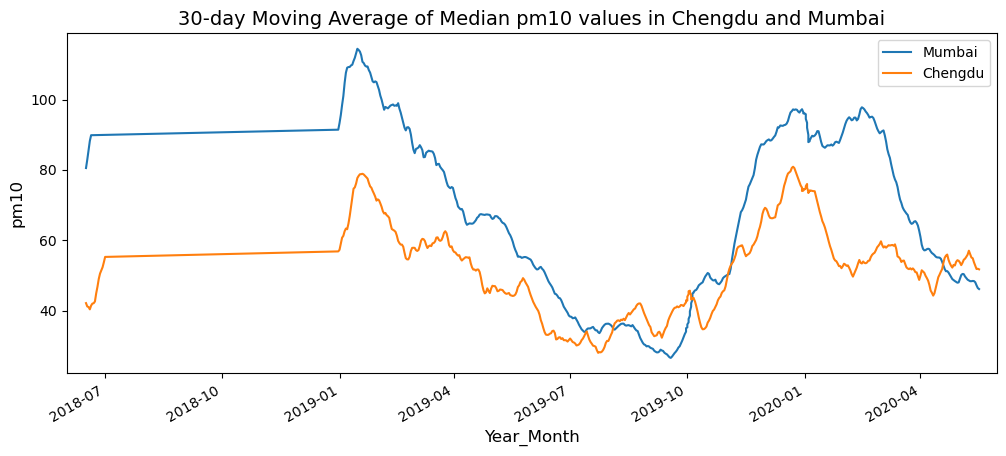

In [87]:
che_mum_air_specie("pm10")

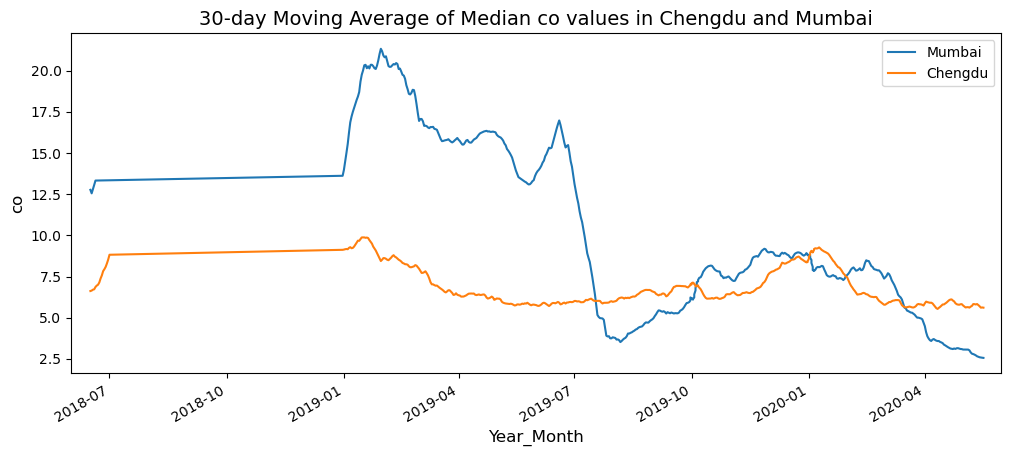

In [88]:
che_mum_air_specie("co")

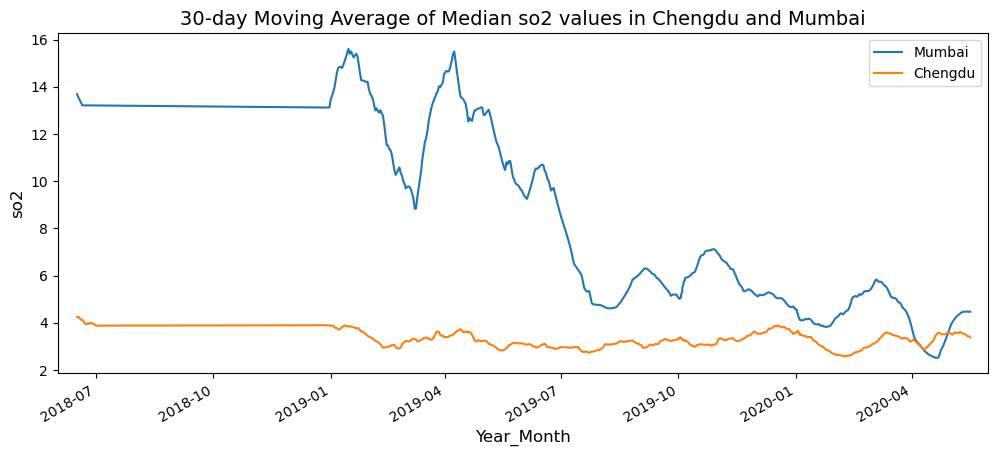

In [89]:
che_mum_air_specie("so2")

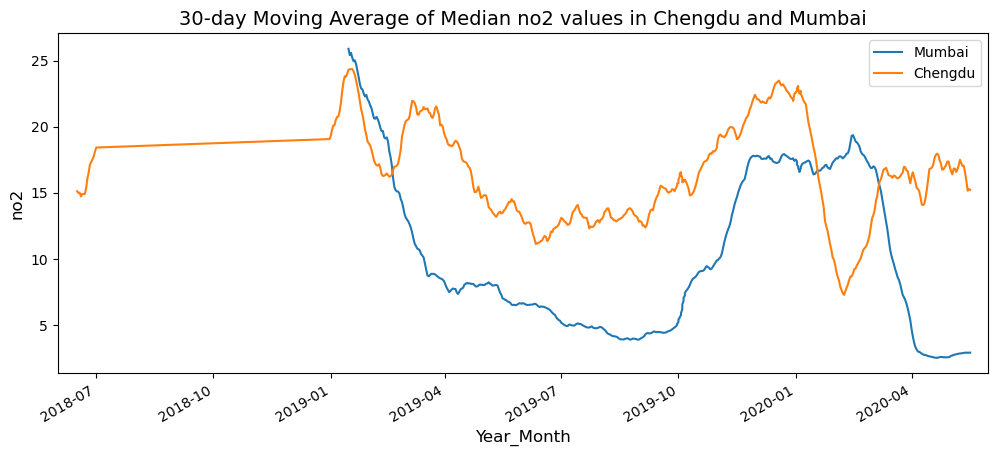

In [90]:
che_mum_air_specie("no2")

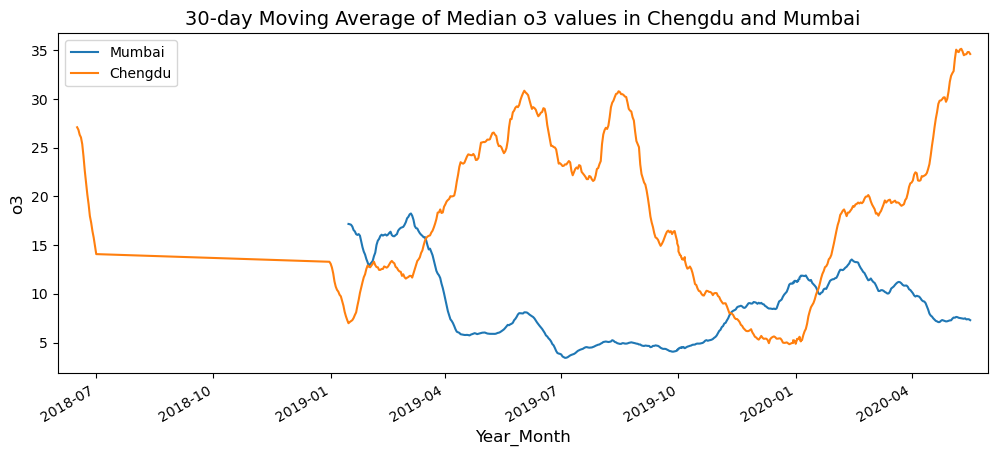

In [91]:
che_mum_air_specie("o3")

* Chengdu and Mumbai comprisons yield interesting results
>
>o3 and no2 levels in Chengdu are higher than in Mumbai, suggesting increased elevation of Chengdu makes it susceptible to these 2 air pollutants
>
>On other parameters such as pm25, pm10, co, so2 Mumbai scores higher though its smaller than Chengdu and a coastal city, suggesting Mumbai can learn from Chengdu in terms of managing these air pollutants through clean technology

## Exploring correlation between city elevation and air quality

### Scatter plots of elevations of a city and air quality

In [92]:
# Transpose the clean_airdf so that the species will become the columns.
rslt_transposed_df = rslt_df.pivot_table(index=["City", "Country", "elevation"], columns="Specie",values = "median").copy()
rslt_transposed_df.reset_index(inplace=True)

rslt_transposed_df.head(200)

Specie,City,Country,elevation,co,no2,o3,pm10,pm25,so2
0,Abha,SA,333.0,6.201439,1.850962,28.686469,7.961415,NaN,1.553425
1,Adana,TR,17.0,2.121861,12.972694,13.068773,24.312160,NaN,4.815371
2,Adapazarı,TR,4.0,15.704220,11.469875,22.299643,38.358289,67.783929,16.526381
3,Akita,JP,147.0,2.853050,5.403757,28.843750,10.039286,42.806798,1.742857
4,Almaty,KZ,215.0,NaN,NaN,NaN,NaN,59.990566,NaN
...,...,...,...,...,...,...,...,...,...
195,Salamanca,ES,3.0,0.100000,4.367321,24.567225,15.941071,21.916667,1.553333
196,Salem,US,179.0,NaN,NaN,11.722111,NaN,23.345588,NaN
197,Salt Lake City,US,4.0,2.028851,10.638631,26.556968,NaN,23.002445,NaN
198,Salzburg,AT,577.0,0.100000,13.724334,NaN,14.872114,NaN,1.567380


In [93]:
#csv export
rslt_transposed_df.to_csv("rslt_test.csv")

In [94]:
# Isolting data for each air pollutant starting with co

co_plot_data = rslt_transposed_df[rslt_transposed_df['co']>0]
co_plot_data.head()

Specie,City,Country,elevation,co,no2,o3,pm10,pm25,so2
0,Abha,SA,333.0,6.201439,1.850962,28.686469,7.961415,NaN,1.553425
1,Adana,TR,17.0,2.121861,12.972694,13.068773,24.312160,NaN,4.815371
2,Adapazarı,TR,4.0,15.704220,11.469875,22.299643,38.358289,67.783929,16.526381
3,Akita,JP,147.0,2.853050,5.403757,28.843750,10.039286,42.806798,1.742857
6,Amsterdam,NL,889.0,2.993428,10.791829,18.973357,16.694494,39.893428,0.331439


The r-value is: 0.019183548278077233


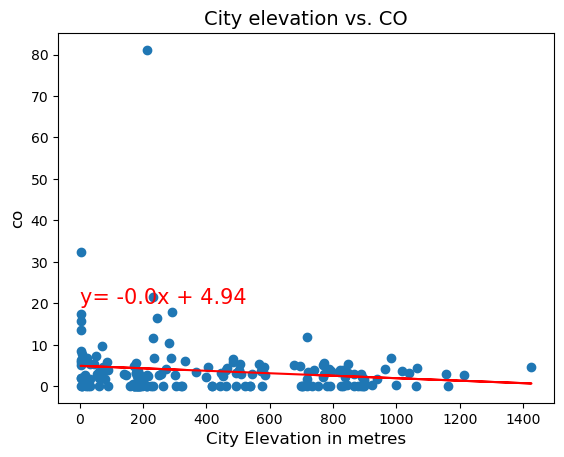

<Figure size 640x480 with 0 Axes>

In [97]:
# Build scatter plot for elevation vs. co

xaxis_data = co_plot_data["elevation"].astype(float)
yaxis_data = co_plot_data["co"].astype(float)
plt.scatter(xaxis_data,yaxis_data)

(m,c,r,p,stderr) = linregress(xaxis_data,yaxis_data)
calc_y = m * xaxis_data + c
eq = "y= " + str(round(m,2)) + "x + " + str(round(c,2))
plt.plot(xaxis_data,calc_y,"r-")
plt.annotate(eq, (0,20), fontsize=15, color="red")
print(f"The r-value is: {r**2}")

plt.xlabel("City Elevation in metres", fontsize=12)
plt.ylabel("co", fontsize=12)
plt.title("City elevation vs. CO", fontsize=14)
plt.show()

# Save the figure
plt.savefig("images/scatterplot_co.png")



In [43]:
# Isolting data for each air pollutant starting with no2

no2_plot_data = rslt_transposed_df[rslt_transposed_df['no2']>0]
no2_plot_data.head()

Specie,City,Country,elevation,co,no2,o3,pm10,pm25,so2
0,Abha,SA,333.0,6.201439,1.850962,28.686469,7.961415,NaN,1.553425
1,Adana,TR,17.0,2.121861,12.972694,13.068773,24.312160,NaN,4.815371
2,Adapazarı,TR,4.0,15.704220,11.469875,22.299643,38.358289,67.783929,16.526381
3,Akita,JP,147.0,2.853050,5.403757,28.843750,10.039286,42.806798,1.742857
5,Amiens,FR,922.0,NaN,5.327191,20.193739,16.062612,40.679487,0.748624


The r-value is: 0.015744765583786412


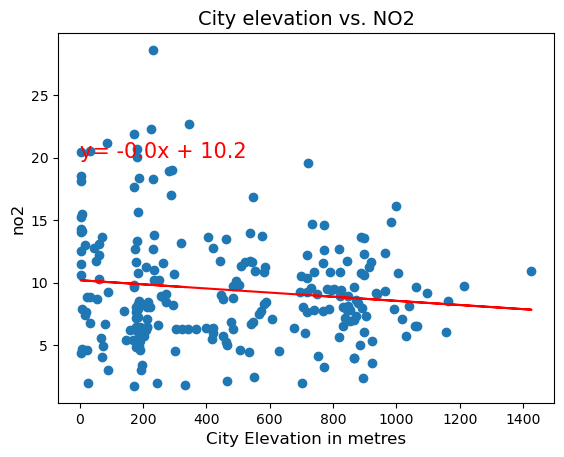

<Figure size 640x480 with 0 Axes>

In [98]:
# Build scatter plot for elevation vs. no2

xaxis_data = no2_plot_data["elevation"].astype(float)
yaxis_data = no2_plot_data["no2"].astype(float)
plt.scatter(xaxis_data,yaxis_data)

(m,c,r,p,stderr) = linregress(xaxis_data,yaxis_data)
calc_y = m * xaxis_data + c
eq = "y= " + str(round(m,2)) + "x + " + str(round(c,2))
plt.plot(xaxis_data,calc_y,"r-")
plt.annotate(eq, (0,20), fontsize=15, color="red")
print(f"The r-value is: {r**2}")

plt.xlabel("City Elevation in metres", fontsize=12)
plt.ylabel("no2", fontsize=12)
plt.title("City elevation vs. NO2", fontsize=14)
plt.show()

# Save the figure
plt.savefig("images/scatterplot_no2.png")

In [45]:
# Isolting data for each air pollutant starting with o3

o3_plot_data = rslt_transposed_df[rslt_transposed_df['o3']>0]
o3_plot_data.head()

Specie,City,Country,elevation,co,no2,o3,pm10,pm25,so2
0,Abha,SA,333.0,6.201439,1.850962,28.686469,7.961415,NaN,1.553425
1,Adana,TR,17.0,2.121861,12.972694,13.068773,24.312160,NaN,4.815371
2,Adapazarı,TR,4.0,15.704220,11.469875,22.299643,38.358289,67.783929,16.526381
3,Akita,JP,147.0,2.853050,5.403757,28.843750,10.039286,42.806798,1.742857
5,Amiens,FR,922.0,NaN,5.327191,20.193739,16.062612,40.679487,0.748624


The r-value is: 0.00960731228579561


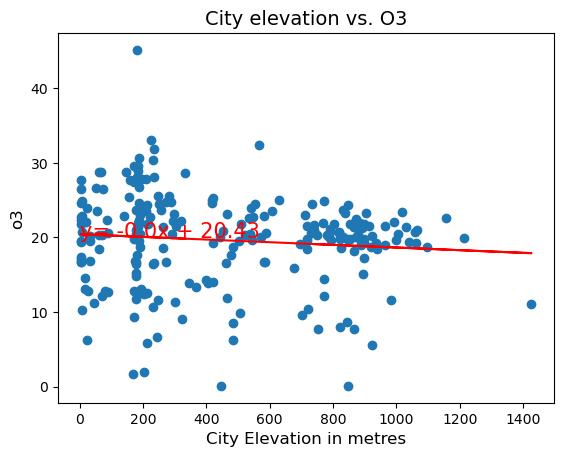

<Figure size 640x480 with 0 Axes>

In [99]:
# Build scatter plot for elevation vs. o3

xaxis_data = o3_plot_data["elevation"].astype(float)
yaxis_data = o3_plot_data["o3"].astype(float)
plt.scatter(xaxis_data,yaxis_data)

(m,c,r,p,stderr) = linregress(xaxis_data,yaxis_data)
calc_y = m * xaxis_data + c
eq = "y= " + str(round(m,2)) + "x + " + str(round(c,2))
plt.plot(xaxis_data,calc_y,"r-")
plt.annotate(eq, (0,20), fontsize=15, color="red")
print(f"The r-value is: {r**2}")

plt.xlabel("City Elevation in metres", fontsize=12)
plt.ylabel("o3", fontsize=12)
plt.title("City elevation vs. O3", fontsize=14)
plt.show()

# Save the figure
plt.savefig("images/scatterplot_o3.png")

In [47]:
# Isolting data for each air pollutant starting with pm10

pm10_plot_data = rslt_transposed_df[rslt_transposed_df['pm10']>0]
pm10_plot_data.head()

Specie,City,Country,elevation,co,no2,o3,pm10,pm25,so2
0,Abha,SA,333.0,6.201439,1.850962,28.686469,7.961415,NaN,1.553425
1,Adana,TR,17.0,2.121861,12.972694,13.068773,24.312160,NaN,4.815371
2,Adapazarı,TR,4.0,15.704220,11.469875,22.299643,38.358289,67.783929,16.526381
3,Akita,JP,147.0,2.853050,5.403757,28.843750,10.039286,42.806798,1.742857
5,Amiens,FR,922.0,NaN,5.327191,20.193739,16.062612,40.679487,0.748624


The r-value is: 0.03782171942266599


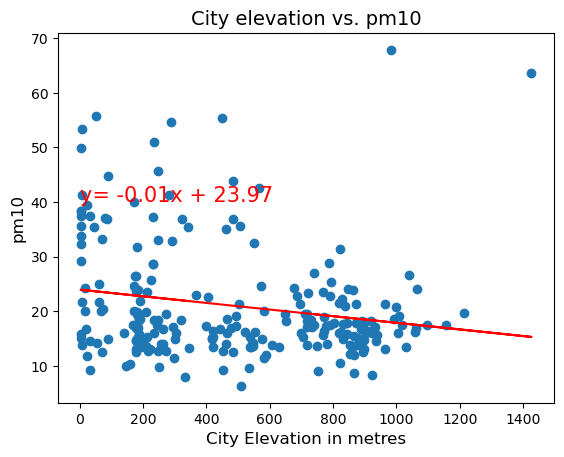

<Figure size 640x480 with 0 Axes>

In [100]:
# Build scatter plot for elevation vs. pm10

xaxis_data = pm10_plot_data["elevation"].astype(float)
yaxis_data = pm10_plot_data["pm10"].astype(float)
plt.scatter(xaxis_data,yaxis_data)

(m,c,r,p,stderr) = linregress(xaxis_data,yaxis_data)
calc_y = m * xaxis_data + c
eq = "y= " + str(round(m,2)) + "x + " + str(round(c,2))
plt.plot(xaxis_data,calc_y,"r-")
plt.annotate(eq, (0,40), fontsize=15, color="red")
print(f"The r-value is: {r**2}")

plt.xlabel("City Elevation in metres", fontsize=12)
plt.ylabel("pm10", fontsize=12)
plt.title("City elevation vs. pm10", fontsize=14)
plt.show()

# Save the figure
plt.savefig("images/scatterplot_pm10.png")

In [49]:
# Isolting data for each air pollutant starting with pm25

pm25_plot_data = rslt_transposed_df[rslt_transposed_df['pm25']>0]
pm25_plot_data.head()

Specie,City,Country,elevation,co,no2,o3,pm10,pm25,so2
2,Adapazarı,TR,4.0,15.704220,11.469875,22.299643,38.358289,67.783929,16.526381
3,Akita,JP,147.0,2.853050,5.403757,28.843750,10.039286,42.806798,1.742857
4,Almaty,KZ,215.0,NaN,NaN,NaN,NaN,59.990566,NaN
5,Amiens,FR,922.0,NaN,5.327191,20.193739,16.062612,40.679487,0.748624
6,Amsterdam,NL,889.0,2.993428,10.791829,18.973357,16.694494,39.893428,0.331439


The r-value is: 0.022410995231161995


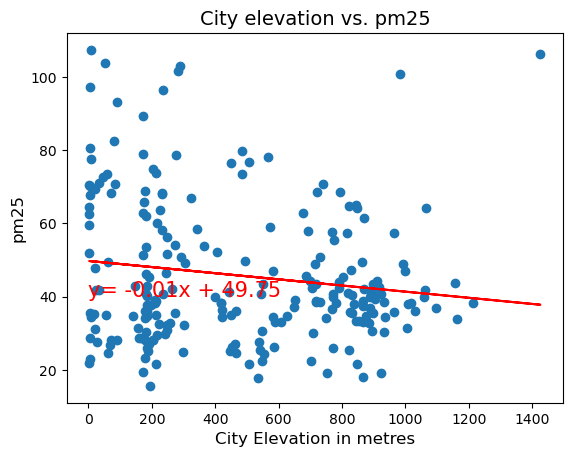

<Figure size 640x480 with 0 Axes>

In [101]:
# Build scatter plot for elevation vs. pm25

xaxis_data = pm25_plot_data["elevation"].astype(float)
yaxis_data = pm25_plot_data["pm25"].astype(float)
plt.scatter(xaxis_data,yaxis_data)

(m,c,r,p,stderr) = linregress(xaxis_data,yaxis_data)
calc_y = m * xaxis_data + c
eq = "y= " + str(round(m,2)) + "x + " + str(round(c,2))
plt.plot(xaxis_data,calc_y,"r-")
plt.annotate(eq, (0,40), fontsize=15, color="red")
print(f"The r-value is: {r**2}")

plt.xlabel("City Elevation in metres", fontsize=12)
plt.ylabel("pm25", fontsize=12)
plt.title("City elevation vs. pm25", fontsize=14)
plt.show()

# Save the figure
plt.savefig("images/scatterplot_pm25.png")

In [51]:
# Isolting data for each air pollutant starting with so2

so2_plot_data = rslt_transposed_df[rslt_transposed_df['so2']>0]
so2_plot_data.head()

Specie,City,Country,elevation,co,no2,o3,pm10,pm25,so2
0,Abha,SA,333.0,6.201439,1.850962,28.686469,7.961415,NaN,1.553425
1,Adana,TR,17.0,2.121861,12.972694,13.068773,24.312160,NaN,4.815371
2,Adapazarı,TR,4.0,15.704220,11.469875,22.299643,38.358289,67.783929,16.526381
3,Akita,JP,147.0,2.853050,5.403757,28.843750,10.039286,42.806798,1.742857
5,Amiens,FR,922.0,NaN,5.327191,20.193739,16.062612,40.679487,0.748624


The r-value is: 0.04564731829317202


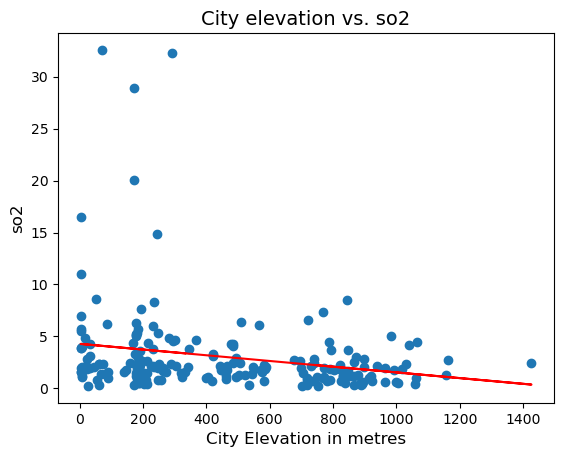

<Figure size 640x480 with 0 Axes>

In [102]:
# Build scatter plot for elevation vs. so2
xaxis_data = so2_plot_data["elevation"].astype(float)
yaxis_data = so2_plot_data["so2"].astype(float)
plt.scatter(xaxis_data,yaxis_data)

(m,c,r,p,stderr) = linregress(xaxis_data,yaxis_data)
calc_y = m * xaxis_data + c
eq = "y= " + str(round(m,2)) + "x + " + str(round(c,2))
plt.plot(xaxis_data,calc_y,"r-")
plt.annotate(eq, (0,40), fontsize=15, color="red")
print(f"The r-value is: {r**2}")

plt.xlabel("City Elevation in metres", fontsize=12)
plt.ylabel("so2", fontsize=12)
plt.title("City elevation vs. so2", fontsize=14)
plt.show()

# Save the figure
plt.savefig("images/scatterplot_so2.png")